# Tensor Deli Datasets

Load the modules, just need the basics here, tensor_sandwhich currently has the dependency on the solver. 

This means cvxpy and SCS, which is non-trivial to get working in an environment

In [43]:
import tensorly as tl
import numpy as np
import matplotlib.pyplot as plt
import tensor_sandwich as ts
from tensorly.decomposition import parafac

#want this for some formatting stuff
import matplotlib as mpl

#need this library to load matlab .mats
import scipy.io
from mpl_toolkits.axes_grid1 import ImageGrid

import pickle

some formatting parameters

In [2]:
plt.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 300

this is a helper function that will display results. publication ready results will need to be tinkered with labels and better titles

In [39]:
def display_results(result,data,real_mask=None):
    d = len(data.shape)
    N = data.shape
    
    recovered_tensor = tl.cp_tensor.CPTensor((result[4][0],result[4][1]))
    if real_mask is None:
        
        full_recovered_tensor = np.real(tl.cp_to_tensor(recovered_tensor))
        
    else:
        full_recovered_tensor = np.real(tl.cp_to_tensor(recovered_tensor))*~real_mask
        print("Adjusted Rel Error without real missing values: ", tl.norm(full_recovered_tensor - data) / tl.norm(data))
        
               
    print("Rel Error \t Matrix Slice Sample Size \t Total Samples \t Prop Revealed")
    print("{:3f} \t {} \t {} \t {:3f} ".format(*result[:4]))
    
    sub_tensor3_idx = [list(range(N[0])),list(range(N[1])),list(range(N[2]))] + [[0] for _ in range(d-3)]
               
    slice_sample_counts = np.sum(result[5][np.ix_(*sub_tensor3_idx)],axis=(0,1))
    slice_rel_errors = np.linalg.norm(full_recovered_tensor[np.ix_(*sub_tensor3_idx)] - data[np.ix_(*sub_tensor3_idx)], axis=(0,1)) / np.linalg.norm(data[np.ix_(*sub_tensor3_idx)], axis=(0,1))

    print("sample counts in slices :,:,i,0 ", slice_sample_counts)
    print("errors in slices :,:,i,0 ", slice_rel_errors)
    
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    
    sub_tensor3_idx[2] = [np.argmin(slice_rel_errors)]
    
    resultant = np.array([full_recovered_tensor[np.ix_(*sub_tensor3_idx)], data[np.ix_(*sub_tensor3_idx)]])
    min_val, max_val = np.amin(resultant), np.amax(resultant)
    
    fig.suptitle("Frontal Slice of Data Tensor")
    plt.subplot(2,2,1)
    plt.title("Data")

    ax[0,0].imshow(np.squeeze( data[np.ix_(*sub_tensor3_idx)]),vmin=min_val, vmax=max_val)

    plt.subplot(2,2,2)
    plt.title("Recovered")
    im = ax[0,1].imshow(np.squeeze( full_recovered_tensor[np.ix_(*sub_tensor3_idx)]), vmin=min_val, vmax=max_val)

   
    # add the colorbar using the figure's method,
    # telling which mappable we're talking about and
    # which axes object it should be near
    fig.colorbar(im, ax=ax[0,1])

    plt.subplot(2,2,3)
    sub_tensor3_idx[2] = [np.argmax(slice_sample_counts)]
     
    plt.imshow(np.squeeze( result[5][np.ix_(*sub_tensor3_idx)]))
    ax[1,0].set_title("Dense Mask")


    plt.subplot(2,2,4)
    sub_tensor3_idx[2] = [np.argmin(slice_sample_counts)]
    plt.imshow(np.squeeze( result[5][np.ix_(*sub_tensor3_idx)]))
    ax[1,1].set_title("Not Dense Mask")


    plt.tight_layout()
    plt.show()

Here's the dataset, can be obtained from https://ucphchemometrics.com/ and I found it through tensorly, which is where I monkey patched the numpy conversion from 

In [4]:
data = np.load('data/Kinetic.npy')
real_mask = np.load('data/Kinetic_missing.npy')

Data comes in with four modes: Concentration, excitation wavelength, emission wavelength and time. For sanity sake, I've hard coded tensor deli to work on modes in a sequential order, so its best if the axis get swaped around up front to the order we want to operate on them. So I swap excitation and time modes: so we're now looking at CONCENTRATION X TIME X EMISSION WAVELENGH X EXCITATION WAVELENGTH

The data also has for real missing values (they are zeros in the data matrix) but there's a mask with it as well. It's a pretty small number, so nothing to get too excited about.

In [5]:
print("Shape of tensor: ", data.shape)
print("Mask of for real missing values: ", real_mask.shape)

#The way deli is set up now, it always processes the modes in order starting at zero. 
#This means the user should first position the axis how they want

data = np.swapaxes(data,1,3)
real_mask = np.swapaxes(real_mask,1,3)

print("Shape of tensor: ", data.shape)
print("Mask of for real missing values: ", real_mask.shape)
print("Count of for real missing values: ", np.sum(real_mask))
print("Missing values as percent: ", 100*np.sum(real_mask) / real_mask.size)


Shape of tensor:  (64, 12, 10, 60)
Mask of for real missing values:  (64, 12, 10, 60)
Shape of tensor:  (64, 60, 10, 12)
Mask of for real missing values:  (64, 60, 10, 12)
Count of for real missing values:  1754
Missing values as percent:  0.3806423611111111


Here are the labels for the modes (not really that important to us?). Need to look into what they mean by outlier measurements -- probably should throw these slices out when it comes time to finish this.

In [6]:
outlier_measurements_idx = [34, 35, 44, 45, 63]  # given as python indexes
excitation_wavelengths = [362 + 6 * i for i in range(10)]
emission_wavelengths = [472 + 7.5 * i for i in range(12)]
time_stamps = [(i + 1) / 3 for i in range(60)]
experiments_idx = [i + 1 for i in range(64)]

ticks=[
            experiments_idx,
            emission_wavelengths,
            excitation_wavelengths,
            time_stamps,
        ]
    
ticks_labels=[
            "Measurements",
            "Emission wavelength (nm)",
            "Excitation wavelength (nm)",
            "Time (minutes)",
        ]

Here's what the data looks like. Note it has truly missing data, but its fairly minor

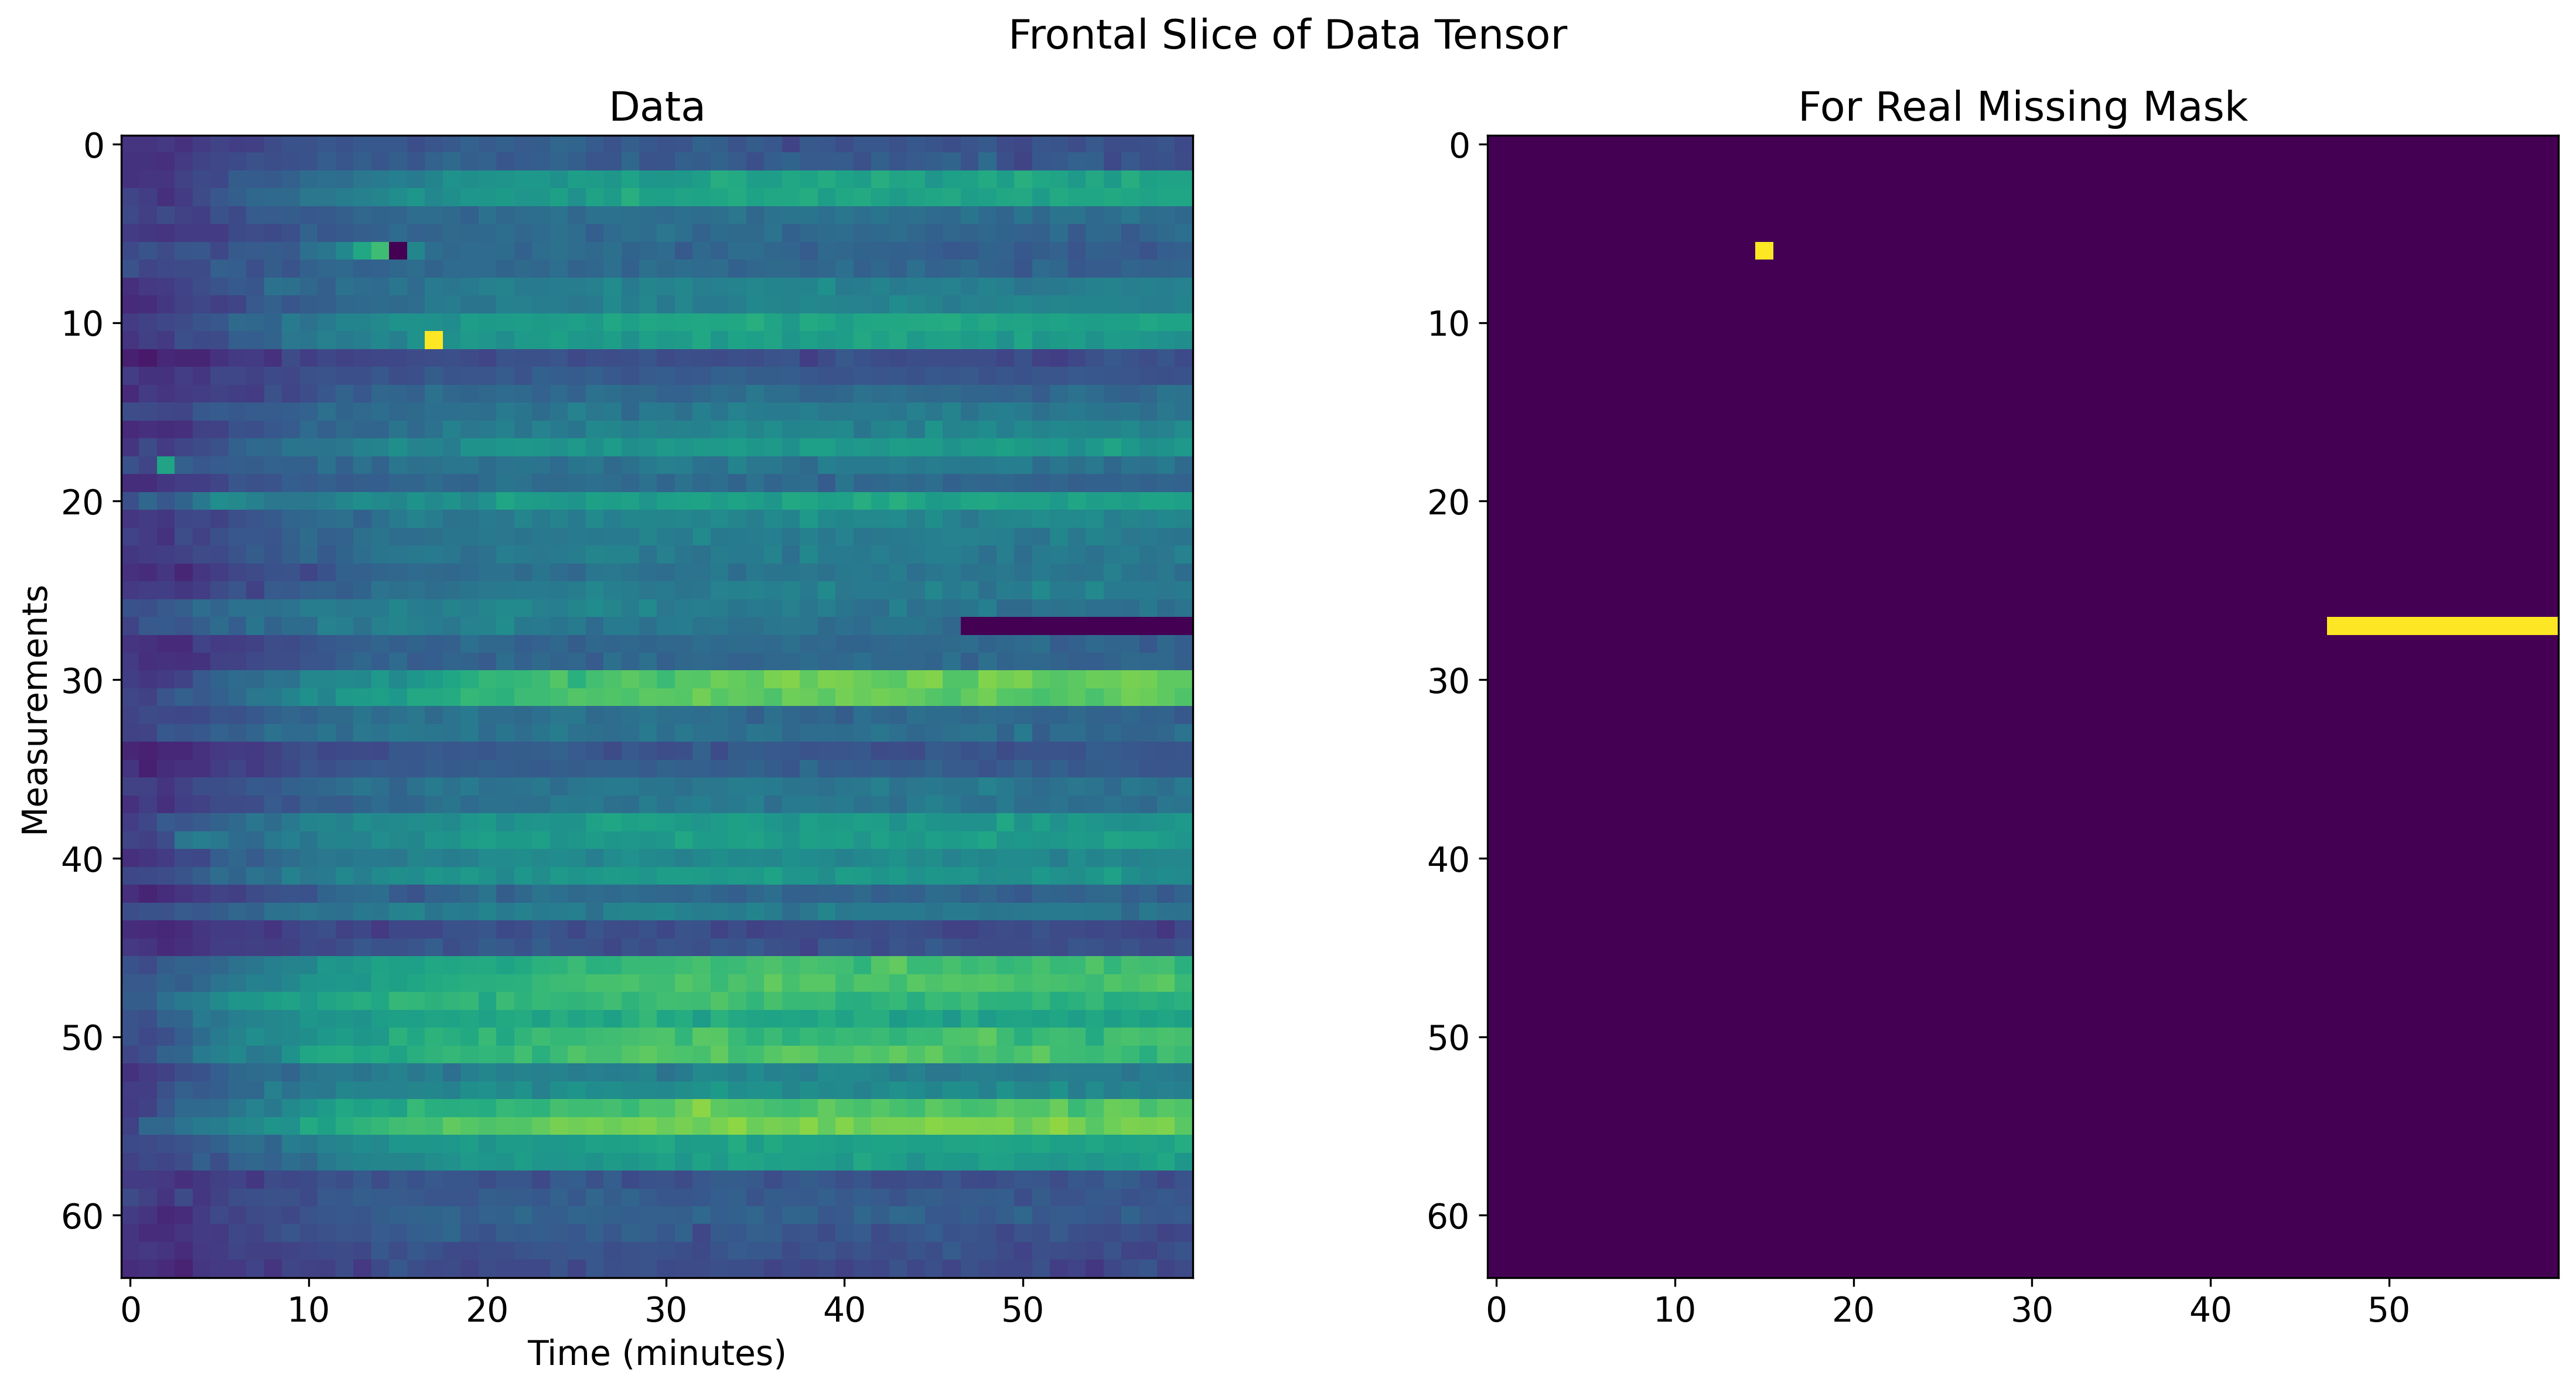

In [7]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

fig.suptitle("Frontal Slice of Data Tensor")
plt.subplot(1,2,1)
plt.title("Data")
plt.imshow(data[:,:,0,0])
plt.xlabel(ticks_labels[3])
plt.ylabel(ticks_labels[0])

plt.subplot(1,2,2)
plt.title("For Real Missing Mask")
plt.imshow(real_mask[:,:,0,0])

plt.tight_layout()
plt.show()

Let's make it a sandwich problem. We'll pick the rank to be as big as the smallest side length, we'll complete four slices. We'll perfectly balance exploitation vs exploration in the matrix sampler, and we'll sample at 50% the entries for the slices. We will do it adapatively and non-adaptively

In [8]:
r=10
n_slices = 4
alpha=1
beta = 0.5
delta = 8
gamma = 0.5
relnoise = 0
result_adaptive = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,adaptive=True,full_output=True)
result_nonadaptive = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,adaptive=False,full_output=True)

Selected slices: [0 2 5 6]
Completing slice:  0
Sample size:  1920
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:03:23 PM: Your problem has 3840 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:03:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:03:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:03:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:03:23 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:03:23 PM: 

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 1.30e-02  1.14e-05  5.62e-02  2.68e+04  2.01e-03  5.92e-01 
   500| 1.25e-07  4.02e-10  6.13e-04  2.68e+04  2.01e-03  1.18e+00 
   750| 5.67e-08  4.04e-10  6.17e-04  2.68e+04  2.01e-03  1.78e+00 
  1000| 5.69e-08  4.03e-10  6.16e-04  2.68e+04  2.01e-03  2.38e+00 
  1250| 5.52e-08  4.23e-10  6.23e-04  2.68e+04  2.01e-03  2.97e+00 
  1500| 7.20e-08  3.83e-10  6.25e-04  2.68e+04  2.01e-03  3.57e+00 
  1750| 5.74e-08  4.09e-10  6.14e-04  2.68e+04  2.01e-03  4.16e+00 
  2000| 2.37e-07  4.37e-10  8.47e-04  2.68e+04  2.01e-03  4.76e+00 
  2250| 2.49e-07  1.75e-10  7.89e-04  2.68e+04  6.32e-04  5.34e+00 
  2500| 2.62e-06  1.74e-10  7.95e-04  2.68e+04  6.32e-04  5.90e+00 
  2750| 1.98e-06  2.64e-10  8.69e-04  2.68e+04  6.32e-04  6.47e+00 
  3000| 1.69e-06  3.16e-10  8.69e-04  2.68e+04  6.32e-04  7.03e+00 
  3250| 2.33e-06  1.95e-10  8.67e-04  2.68e+04  6.32e-04  7.59e+00 
  3500| 2.49e-07  1.78e-10  7.89e-04  2.68e+04  6.32e-04  8.16e+00 
  3750| 4.31e-06  4.64e-10  7.93e-04  2.68e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 2.30e-02  3.63e-05  6.62e-02  3.49e+04  2.15e-03  5.92e-01 
   500| 3.57e-08  4.56e-10  8.85e-04  3.49e+04  2.15e-03  1.19e+00 
   750| 4.02e-07  1.38e-10  1.29e-03  3.49e+04  6.57e-04  1.79e+00 
  1000| 1.58e-07  1.87e-10  1.13e-03  3.49e+04  6.57e-04  2.40e+00 
  1250| 3.29e-07  1.91e-10  1.12e-03  3.49e+04  6.57e-04  3.01e+00 
  1500| 3.55e-07  1.28e-10  1.28e-03  3.49e+04  6.57e-04  3.61e+00 
  1750| 3.57e-07  1.34e-10  1.25e-03  3.49e+04  6.57e-04  4.22e+00 
  2000| 1.95e-07  1.96e-10  1.11e-03  3.49e+04  6.57e-04  4.83e+00 
  2250| 2.46e-07  1.93e-10  1.13e-03  3.49e+04  6.57e-04  5.44e+00 
  2500| 1.07e-06  1.98e-10  1.12e-03  3.49e+04  6.57e-04  6.04e+00 
  2750| 2.11e-07  1.92e-10  1.13e-03  3.49e+04  6.57e-04  6.64e+00 
  3000| 4.74e-07  1.91e-10  1.13e-03  3.49e+04  6.57e-04  7.25e+00 
  3250| 4.98e-07  2.06e-10  1.11e-03  3.49e+04  6.57e-04  7.85e+00 
  3500| 4.50e-07  2.13e-10  1.21e-03  3.49e+04  6.57e-04  8.46e+00 
  3750| 3.78e-07  1.84e-10  1.14e-03  3.49e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 2.04e-02  3.40e-05  3.14e-02  3.58e+04  2.05e-03  5.93e-01 
   500| 5.95e-08  4.38e-10  9.43e-04  3.58e+04  2.05e-03  1.20e+00 
   750| 1.10e-07  1.54e-10  1.23e-03  3.58e+04  6.39e-04  1.82e+00 
  1000| 1.26e-07  1.69e-10  1.21e-03  3.58e+04  6.39e-04  2.42e+00 
  1250| 1.36e-07  1.54e-10  1.23e-03  3.58e+04  6.39e-04  3.04e+00 
  1500| 5.21e-07  1.63e-10  1.22e-03  3.58e+04  6.39e-04  3.65e+00 
  1750| 1.19e-07  1.57e-10  1.22e-03  3.58e+04  6.39e-04  4.28e+00 
  2000| 2.30e-07  1.16e-10  1.37e-03  3.58e+04  6.39e-04  4.88e+00 
  2250| 1.47e-07  1.38e-10  1.24e-03  3.58e+04  6.39e-04  5.49e+00 
  2500| 1.42e-07  1.29e-10  1.25e-03  3.58e+04  6.39e-04  6.10e+00 
  2750| 2.23e-06  1.99e-10  1.26e-03  3.58e+04  6.39e-04  6.72e+00 
  3000| 2.14e-07  8.10e-11  1.34e-03  3.58e+04  6.39e-04  7.33e+00 
  3250| 7.08e-07  1.51e-10  1.23e-03  3.58e+04  6.39e-04  7.94e+00 
  3500| 1.64e-07  1.07e-10  1.46e-03  3.58e+04  6.39e-04  8.55e+00 
  3750| 1.50e-07  1.57e-10  1.22e-03  3.58e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 1.23e-02  1.67e-05  2.12e-02  3.05e+04  2.55e-03  5.97e-01 
   500| 1.11e-07  4.84e-10  5.79e-04  3.05e+04  2.55e-03  1.20e+00 
   750| 1.62e-07  2.05e-10  8.11e-04  3.05e+04  7.95e-04  1.80e+00 
  1000| 7.28e-07  1.99e-10  8.15e-04  3.05e+04  7.95e-04  2.40e+00 
  1250| 2.16e-07  2.17e-10  8.13e-04  3.05e+04  7.95e-04  3.00e+00 
  1500| 3.64e-07  1.99e-10  8.19e-04  3.05e+04  7.95e-04  3.60e+00 
  1750| 1.44e-07  1.92e-10  8.23e-04  3.05e+04  7.95e-04  4.19e+00 
  2000| 1.54e-07  1.96e-10  8.21e-04  3.05e+04  7.95e-04  4.78e+00 
  2250| 9.79e-07  2.12e-10  8.09e-04  3.05e+04  7.95e-04  5.37e+00 
  2500| 2.52e-07  2.02e-10  8.11e-04  3.05e+04  7.95e-04  5.97e+00 
  2750| 1.50e-07  1.91e-10  8.26e-04  3.05e+04  7.95e-04  6.56e+00 
  3000| 1.47e-06  1.78e-10  9.46e-04  3.05e+04  7.95e-04  7.15e+00 
  3250| 1.55e-07  1.96e-10  8.17e-04  3.05e+04  7.95e-04  7.75e+00 
  3500| 1.75e-03  2.15e-07  7.95e-03  3.05e+04  7.95e-04  8.35e+00 
  3750| 2.81e-05  3.49e-09  6.15e-04  3.05e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 2.03e-02  1.20e-05  1.11e-01  3.59e+04  2.03e-03  5.94e-01 
   500| 9.16e-08  4.15e-10  8.49e-04  3.59e+04  2.03e-03  1.20e+00 
   750| 6.28e-07  7.62e-10  1.29e-03  3.59e+04  2.03e-03  1.82e+00 
  1000| 1.80e-07  1.45e-10  1.08e-03  3.59e+04  6.36e-04  2.43e+00 
  1250| 1.07e-07  1.10e-10  1.11e-03  3.59e+04  6.36e-04  3.04e+00 
  1500| 3.35e-07  1.32e-10  1.10e-03  3.59e+04  6.36e-04  3.65e+00 
  1750| 2.10e-07  2.08e-10  1.24e-03  3.59e+04  6.36e-04  4.27e+00 
  2000| 4.48e-07  9.60e-11  1.21e-03  3.59e+04  6.36e-04  4.95e+00 
  2250| 2.94e-06  5.97e-10  9.30e-04  3.59e+04  6.36e-04  5.56e+00 
  2500| 3.11e-06  6.01e-10  8.75e-04  3.59e+04  6.36e-04  6.16e+00 
  2750| 3.86e-05  8.09e-09  9.24e-04  3.59e+04  6.36e-04  6.77e+00 
  3000| 2.65e-07  7.87e-11  1.17e-03  3.59e+04  6.36e-04  7.38e+00 
  3250| 1.46e-07  1.34e-10  1.09e-03  3.59e+04  6.36e-04  7.99e+00 
  3500| 7.01e-07  1.11e-10  1.22e-03  3.59e+04  6.36e-04  8.60e+00 
  3750| 2.44e-07  1.13e-10  1.11e-03  3.59e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 4.40e-02  8.23e-06  2.11e-01  3.69e+04  1.78e-03  5.92e-01 
   500| 1.24e-07  4.46e-10  8.64e-04  3.69e+04  1.78e-03  1.18e+00 
   750| 5.35e-07  8.47e-10  1.81e-03  3.69e+04  1.78e-03  1.78e+00 
  1000| 4.28e-08  4.19e-10  8.66e-04  3.69e+04  1.78e-03  2.37e+00 
  1250| 7.51e-07  2.01e-10  1.21e-03  3.69e+04  5.58e-04  2.95e+00 
  1500| 4.02e-07  7.35e-11  1.28e-03  3.69e+04  5.58e-04  3.52e+00 
  1750| 1.91e-07  1.97e-10  1.10e-03  3.69e+04  5.58e-04  4.08e+00 
  2000| 5.19e-07  1.91e-10  1.11e-03  3.69e+04  5.58e-04  4.65e+00 
  2250| 3.49e-07  1.97e-10  1.10e-03  3.69e+04  5.58e-04  5.22e+00 
  2500| 2.69e-07  1.99e-10  1.09e-03  3.69e+04  5.58e-04  5.78e+00 
  2750| 5.65e-07  1.50e-10  1.37e-03  3.69e+04  5.58e-04  6.36e+00 
  3000| 3.40e-07  1.93e-10  1.10e-03  3.69e+04  5.58e-04  6.93e+00 
  3250| 1.20e-06  1.26e-10  1.28e-03  3.69e+04  5.58e-04  7.49e+00 
  3500| 1.88e-07  1.84e-10  1.11e-03  3.69e+04  5.58e-04  8.06e+00 
  3750| 2.09e-07  1.98e-10  1.09e-03  3.69e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 5.03e-03  5.61e-06  2.09e-02  2.71e+04  2.68e-03  5.91e-01 
   500| 1.97e-07  4.92e-10  6.05e-04  2.71e+04  2.68e-03  1.18e+00 
   550| 8.14e-07  2.74e-09  2.23e-04  2.71e+04  2.68e-03  1.30e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.30e+00s = setup: 2.53e-02s + solve: 1.27e+00s
	 lin-sys: 1.63e-01s, cones: 1.05e+00s, accel: 2.03e-02s
------------------------------------------------------------------
objective = 27123.365621
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:06:12 PM: Problem status: optimal
(CVXPY) Sep 27 06:06:12 PM: Optimal value: 2.712e+04
(CVXPY) Sep 27 06:06:12 PM: Compilation took 4.176e-02 seconds
(CVXPY) Sep 27 06:06:12 P

# Adaptive - Kinetic Fluor, 4 Modes

Adjusted Rel Error without real missing values:  0.2821982856219268
Rel Error 	 Matrix Slice Sample Size 	 Total Samples 	 Prop Revealed
0.284652 	 1920 	 9221 	 0.020011 
sample counts in slices :,:,i,0  [[1963]
 [  80]
 [1962]
 [  80]
 [  80]
 [1970]
 [1966]
 [  80]
 [  80]
 [  80]]
errors in slices :,:,i,0  [[0.18055621]
 [0.15578779]
 [0.13289807]
 [0.13302611]
 [0.14857163]
 [0.08177878]
 [0.08902083]
 [0.1140034 ]
 [0.11526152]
 [0.16853127]]


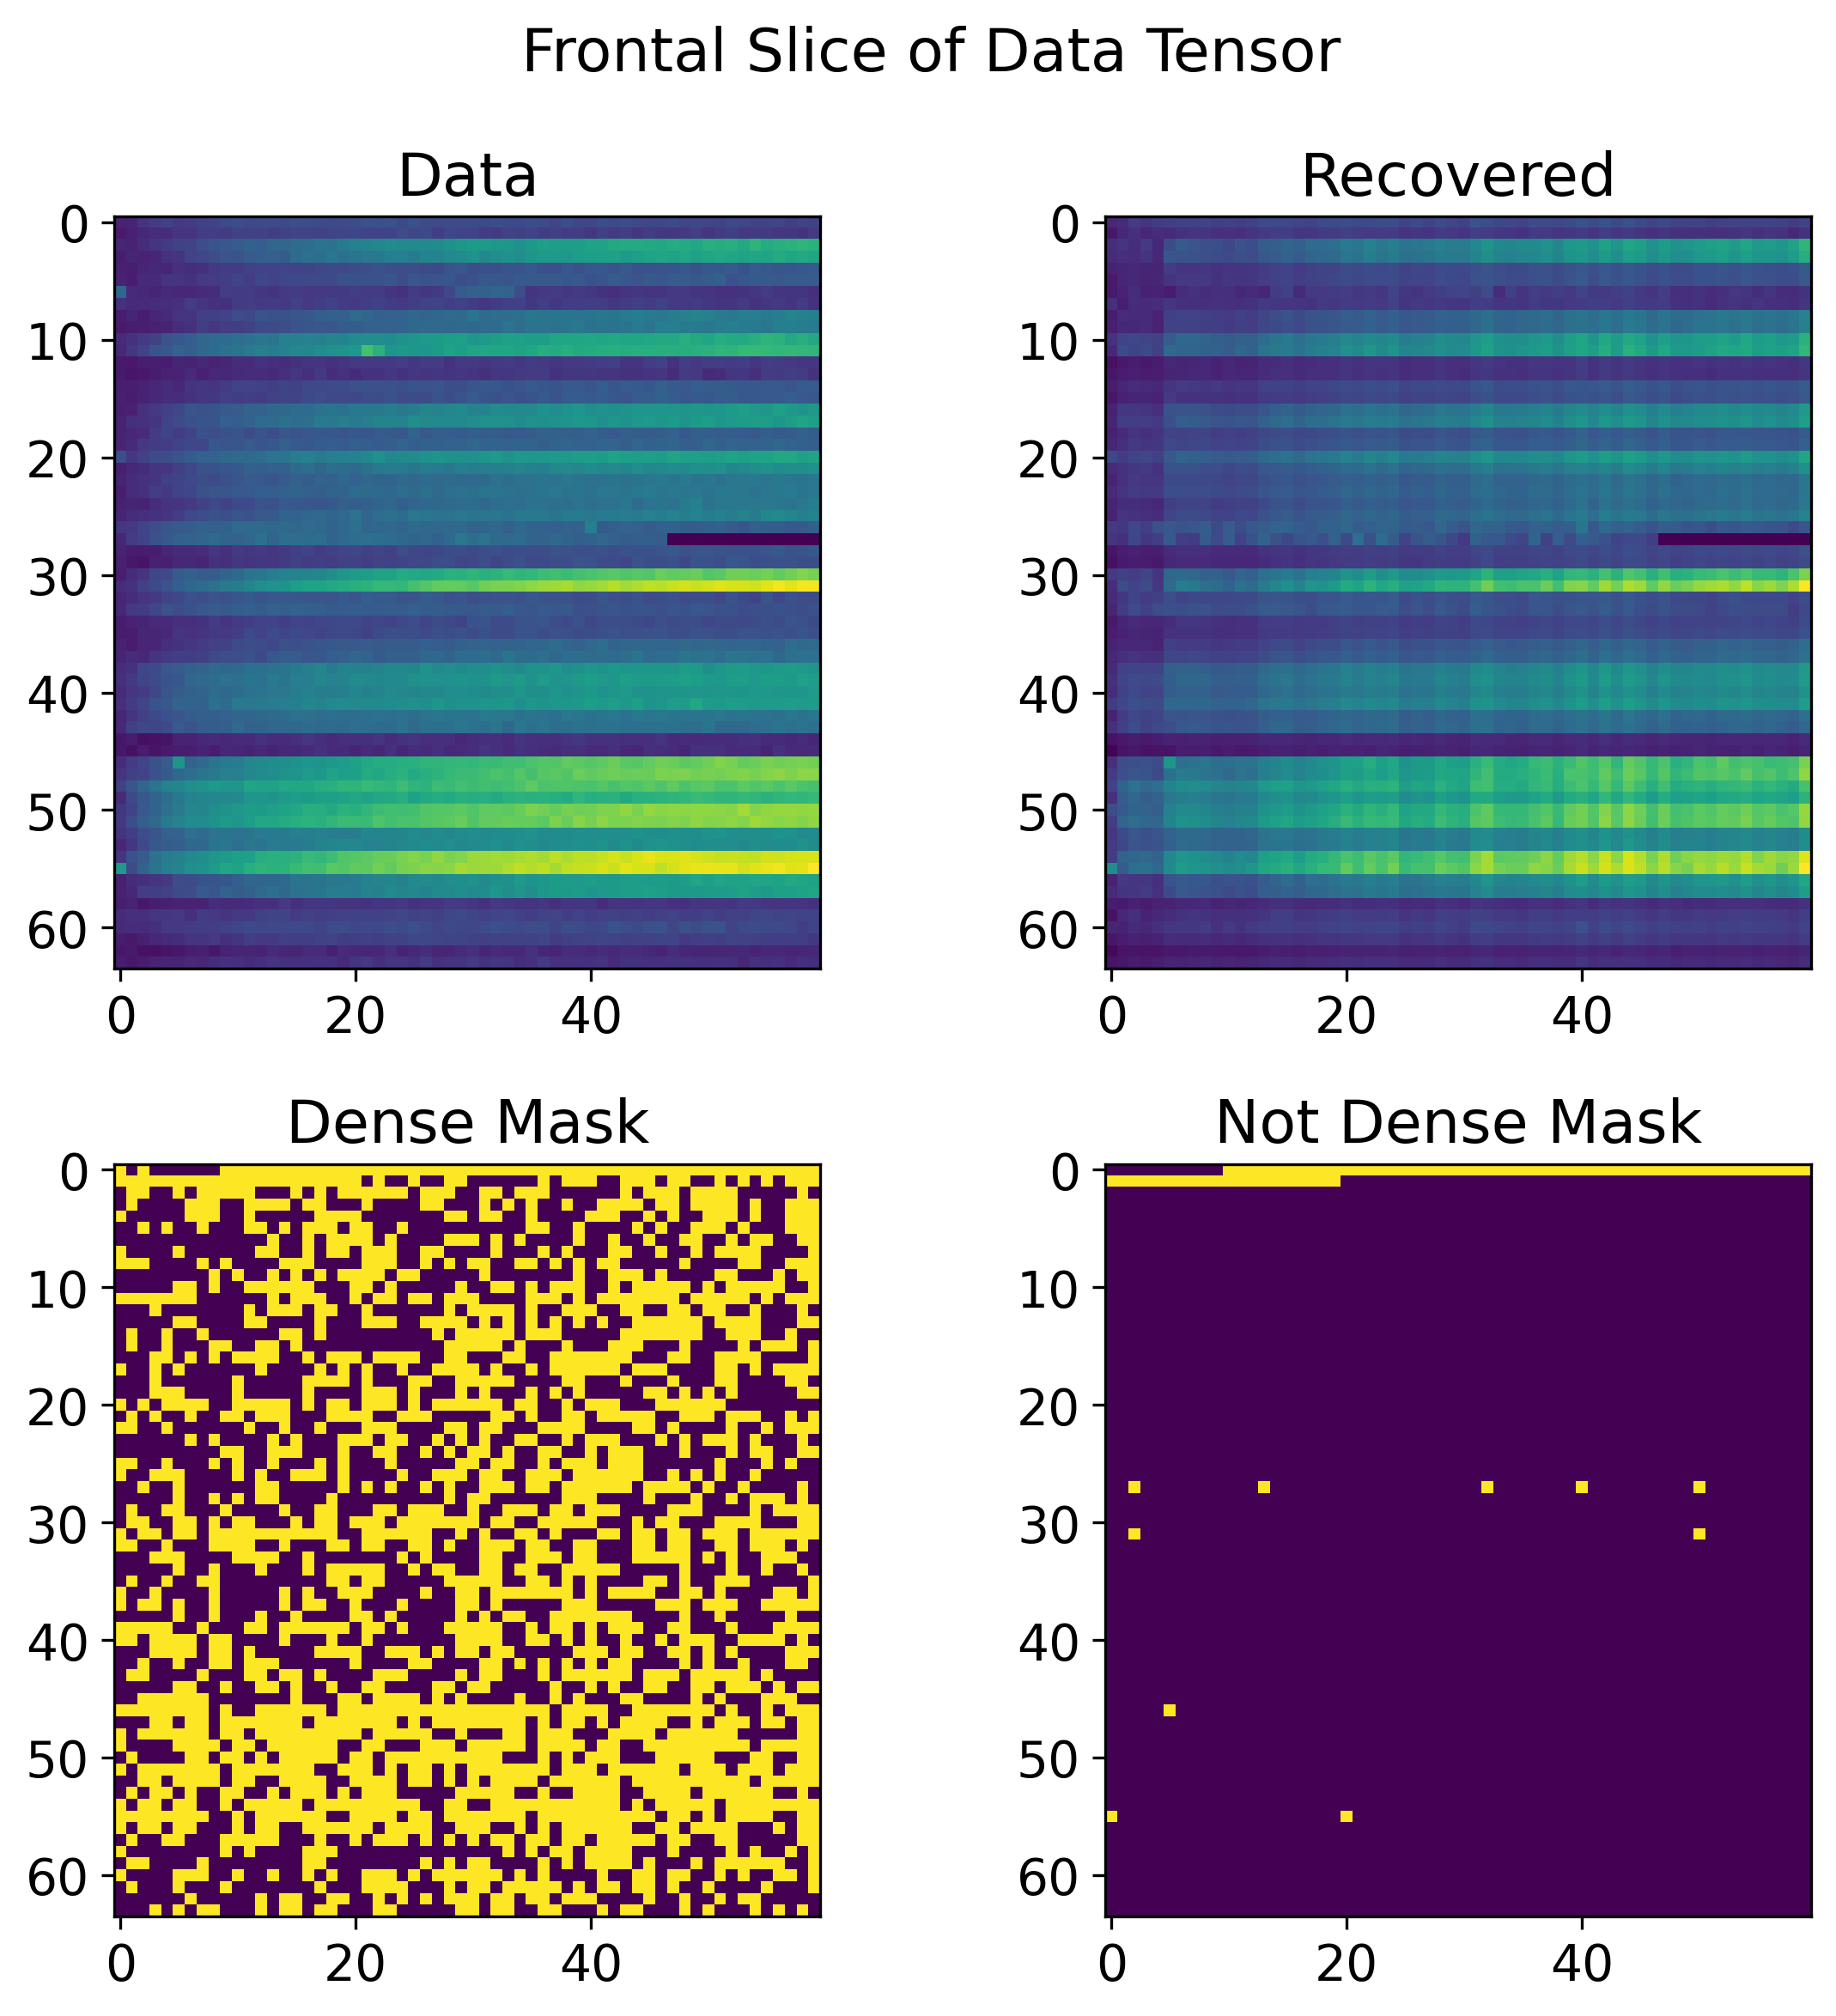

In [9]:
display_results(result_adaptive,data,real_mask=real_mask)

# Non-adaptive - Kinetic Fluor, 4 Mode

Adjusted Rel Error without real missing values:  0.3856754517846145
Rel Error 	 Matrix Slice Sample Size 	 Total Samples 	 Prop Revealed
0.386972 	 1920 	 9296 	 0.020174 
sample counts in slices :,:,i,0  [[ 158]
 [  67]
 [1968]
 [1954]
 [  85]
 [  91]
 [1965]
 [  71]
 [1972]
 [  90]]
errors in slices :,:,i,0  [[0.17590137]
 [0.18295237]
 [0.14138995]
 [0.17312555]
 [0.20813628]
 [0.2286073 ]
 [0.2166363 ]
 [0.23298431]
 [0.2041729 ]
 [0.26135238]]


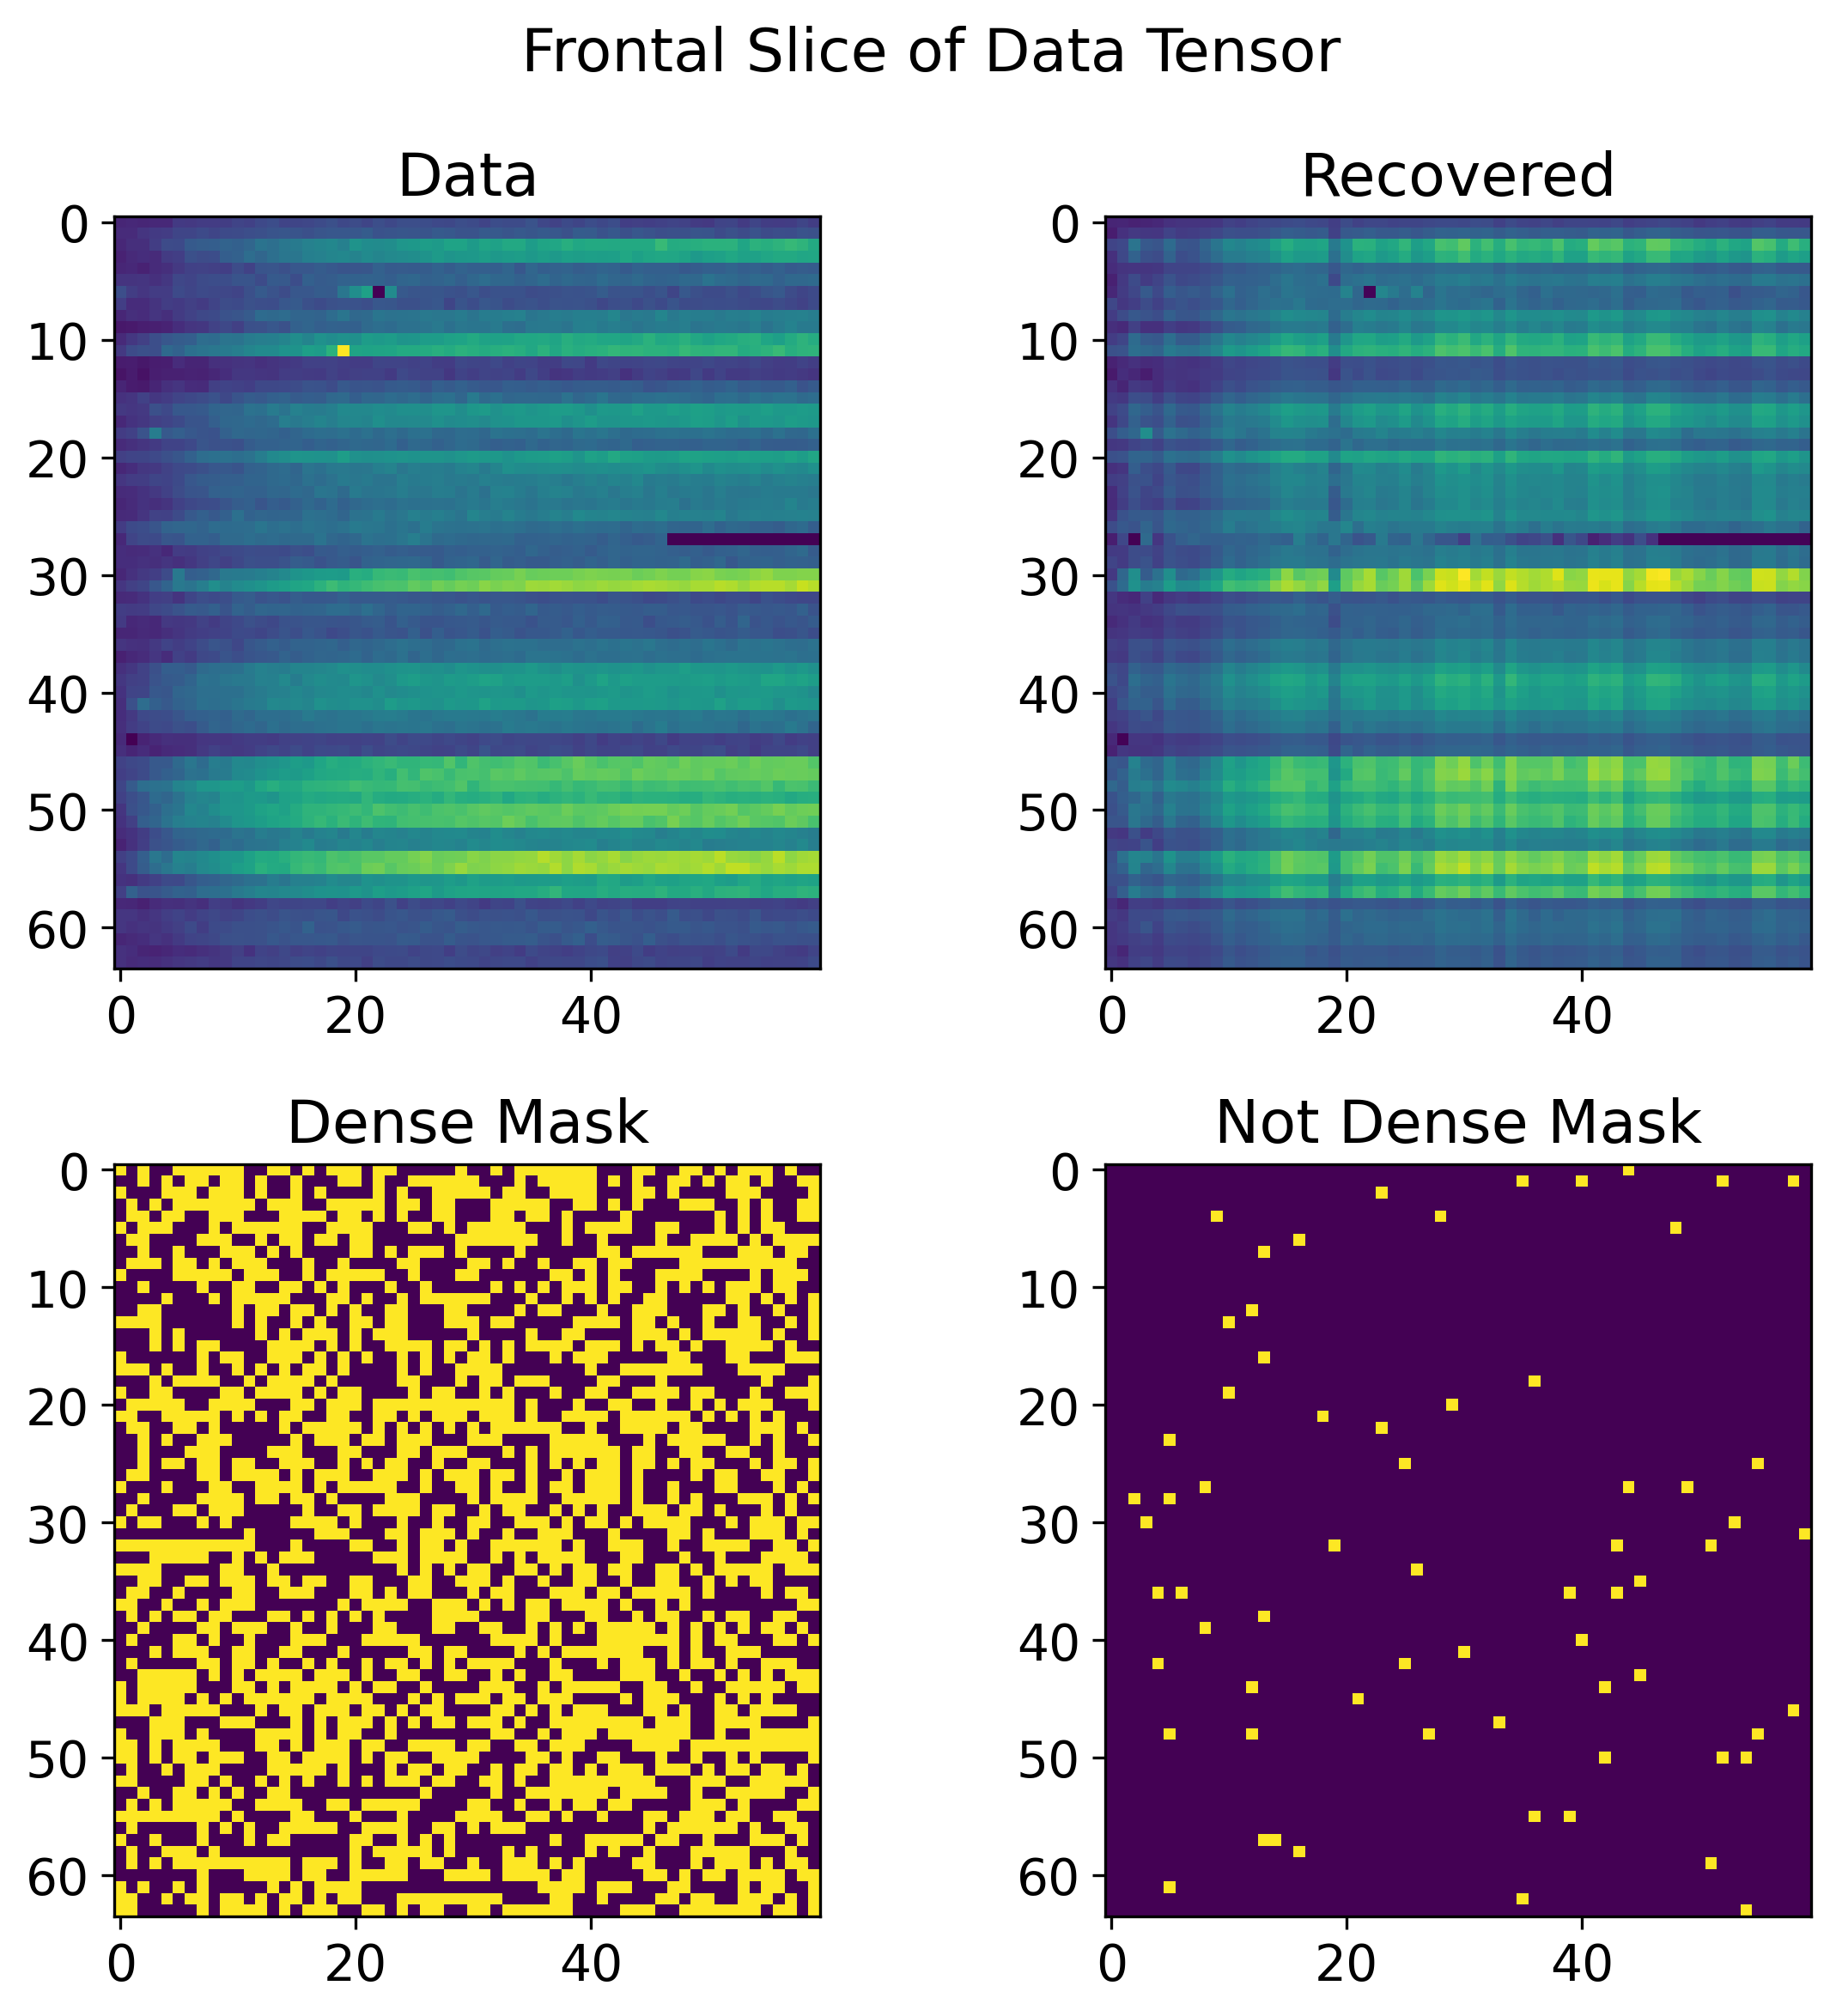

In [10]:
display_results(result_nonadaptive,data,real_mask=real_mask)

Okay, as you can see, this is off, but also not way off

# Adaptive, Inner-ALS - Fluor, 4-mode

In [14]:
result_inner_als = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,adaptive=True,inner_als=True, full_output=True)

Selected slices: [5 3 7 4]
Completing slice:  5
Sample size:  1920
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:13:01 PM: Your problem has 3840 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:13:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:13:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:13:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:13:01 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:13:01 PM: 

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 1.43e-02  2.26e-05  5.22e-02  3.06e+04  2.05e-03  5.92e-01 
   500| 7.26e-08  4.42e-10  7.12e-04  3.06e+04  2.05e-03  1.19e+00 
   750| 7.09e-07  8.94e-10  1.02e-03  3.06e+04  2.05e-03  1.80e+00 
  1000| 4.87e-08  4.34e-10  7.21e-04  3.06e+04  2.05e-03  2.42e+00 
  1250| 1.46e-07  4.56e-10  7.16e-04  3.06e+04  2.05e-03  3.08e+00 
  1500| 2.21e-07  1.87e-10  9.27e-04  3.06e+04  6.43e-04  3.67e+00 
  1750| 3.59e-07  1.96e-10  9.29e-04  3.06e+04  6.43e-04  4.27e+00 
  2000| 9.41e-07  1.78e-10  9.31e-04  3.06e+04  6.43e-04  4.86e+00 
  2250| 2.19e-07  1.89e-10  9.31e-04  3.06e+04  6.43e-04  5.45e+00 
  2500| 8.29e-07  1.84e-10  9.30e-04  3.06e+04  6.43e-04  6.05e+00 
  2750| 4.44e-07  1.25e-10  1.05e-03  3.06e+04  6.43e-04  6.64e+00 
  3000| 2.11e-07  1.83e-10  9.32e-04  3.06e+04  6.43e-04  7.23e+00 
  3250| 1.60e-06  1.80e-10  9.35e-04  3.06e+04  6.43e-04  7.83e+00 
  3500| 8.54e-07  1.69e-10  9.46e-04  3.06e+04  6.43e-04  8.42e+00 
  3750| 5.24e-07  1.73e-10  9.47e-04  3.06e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 1.44e-02  3.02e-05  5.08e-02  3.68e+04  1.87e-03  5.90e-01 
   500| 3.36e-05  6.53e-10  1.42e-03  3.68e+04  5.78e-04  1.18e+00 
   750| 2.50e-06  1.32e-10  1.30e-03  3.68e+04  5.78e-04  1.77e+00 
  1000| 1.31e-07  1.07e-10  1.32e-03  3.68e+04  5.78e-04  2.37e+00 
  1250| 2.00e-07  1.30e-10  1.29e-03  3.68e+04  5.78e-04  2.97e+00 
  1500| 1.54e-07  1.49e-10  1.26e-03  3.68e+04  5.78e-04  3.57e+00 
  1750| 8.43e-07  1.11e-10  1.37e-03  3.68e+04  5.78e-04  4.17e+00 
  2000| 1.49e-07  1.28e-10  1.29e-03  3.68e+04  5.78e-04  4.77e+00 
  2250| 1.57e-07  1.38e-10  1.28e-03  3.68e+04  5.78e-04  5.37e+00 
  2500| 1.51e-07  1.32e-10  1.29e-03  3.68e+04  5.78e-04  5.97e+00 
  2750| 1.33e-07  1.19e-10  1.30e-03  3.68e+04  5.78e-04  6.57e+00 
  3000| 1.27e-07  1.16e-10  1.31e-03  3.68e+04  5.78e-04  7.16e+00 
  3250| 1.37e-07  1.21e-10  1.30e-03  3.68e+04  5.78e-04  7.76e+00 
  3500| 6.59e-07  1.07e-10  1.38e-03  3.68e+04  5.78e-04  8.37e+00 
  3750| 2.88e-07  1.23e-10  1.36e-03  3.68e+04  

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   250| 1.93e-02  6.66e-06  7.15e-02  3.26e+04  7.20e-04  5.86e-01 
   500| 6.93e-06  2.66e-10  9.67e-04  3.26e+04  7.20e-04  1.18e+00 
   750| 1.83e-07  2.14e-10  9.88e-04  3.26e+04  7.20e-04  1.78e+00 
  1000| 1.90e-07  2.40e-10  9.66e-04  3.26e+04  7.20e-04  2.38e+00 
  1250| 1.68e-07  2.10e-10  9.89e-04  3.26e+04  7.20e-04  2.98e+00 
  1500| 7.59e-07  2.22e-10  9.84e-04  3.26e+04  7.20e-04  3.58e+00 
  1750| 3.47e-07  2.00e-10  1.00e-03  3.26e+04  7.20e-04  4.18e+00 
  2000| 3.65e-07  2.10e-10  9.90e-04  3.26e+04  7.20e-04  4.79e+00 
  2250| 5.12e-07  1.52e-10  1.13e-03  3.26e+04  7.20e-04  5.39e+00 
  2500| 1.66e-07  2.06e-10  9.95e-04  3.26e+04  7.20e-04  5.99e+00 
  2750| 1.19e-06  3.09e-10  1.07e-03  3.26e+04  7.20e-04  6.59e+00 
  3000| 1.71e-07  2.20e-10  9.83e-04  3.26e+04  7.20e-04  7.19e+00 
  3250| 3.52e-07  1.19e-10  1.14e-03  3.26e+04  7.20e-04  7.80e+00 
  3500| 2.52e-07  2.20e-10  9.86e-04  3.26e+04  7.20e-04  8.40e+00 
  3750| 7.20e-07  2.19e-10  9.82e-04  3.26e+04  

Adjusted Rel Error without real missing values:  0.4402706125597173
Rel Error 	 Matrix Slice Sample Size 	 Total Samples 	 Prop Revealed
0.494156 	 1920 	 9207 	 0.019980 
sample counts in slices :,:,i,0  [[  80]
 [  80]
 [  80]
 [1957]
 [1966]
 [1964]
 [  80]
 [1960]
 [  80]
 [  80]]
errors in slices :,:,i,0  [[0.20345335]
 [0.1615696 ]
 [0.11046303]
 [0.04859411]
 [0.04820634]
 [0.0402458 ]
 [0.07211209]
 [0.04377766]
 [0.1413658 ]
 [0.26939665]]


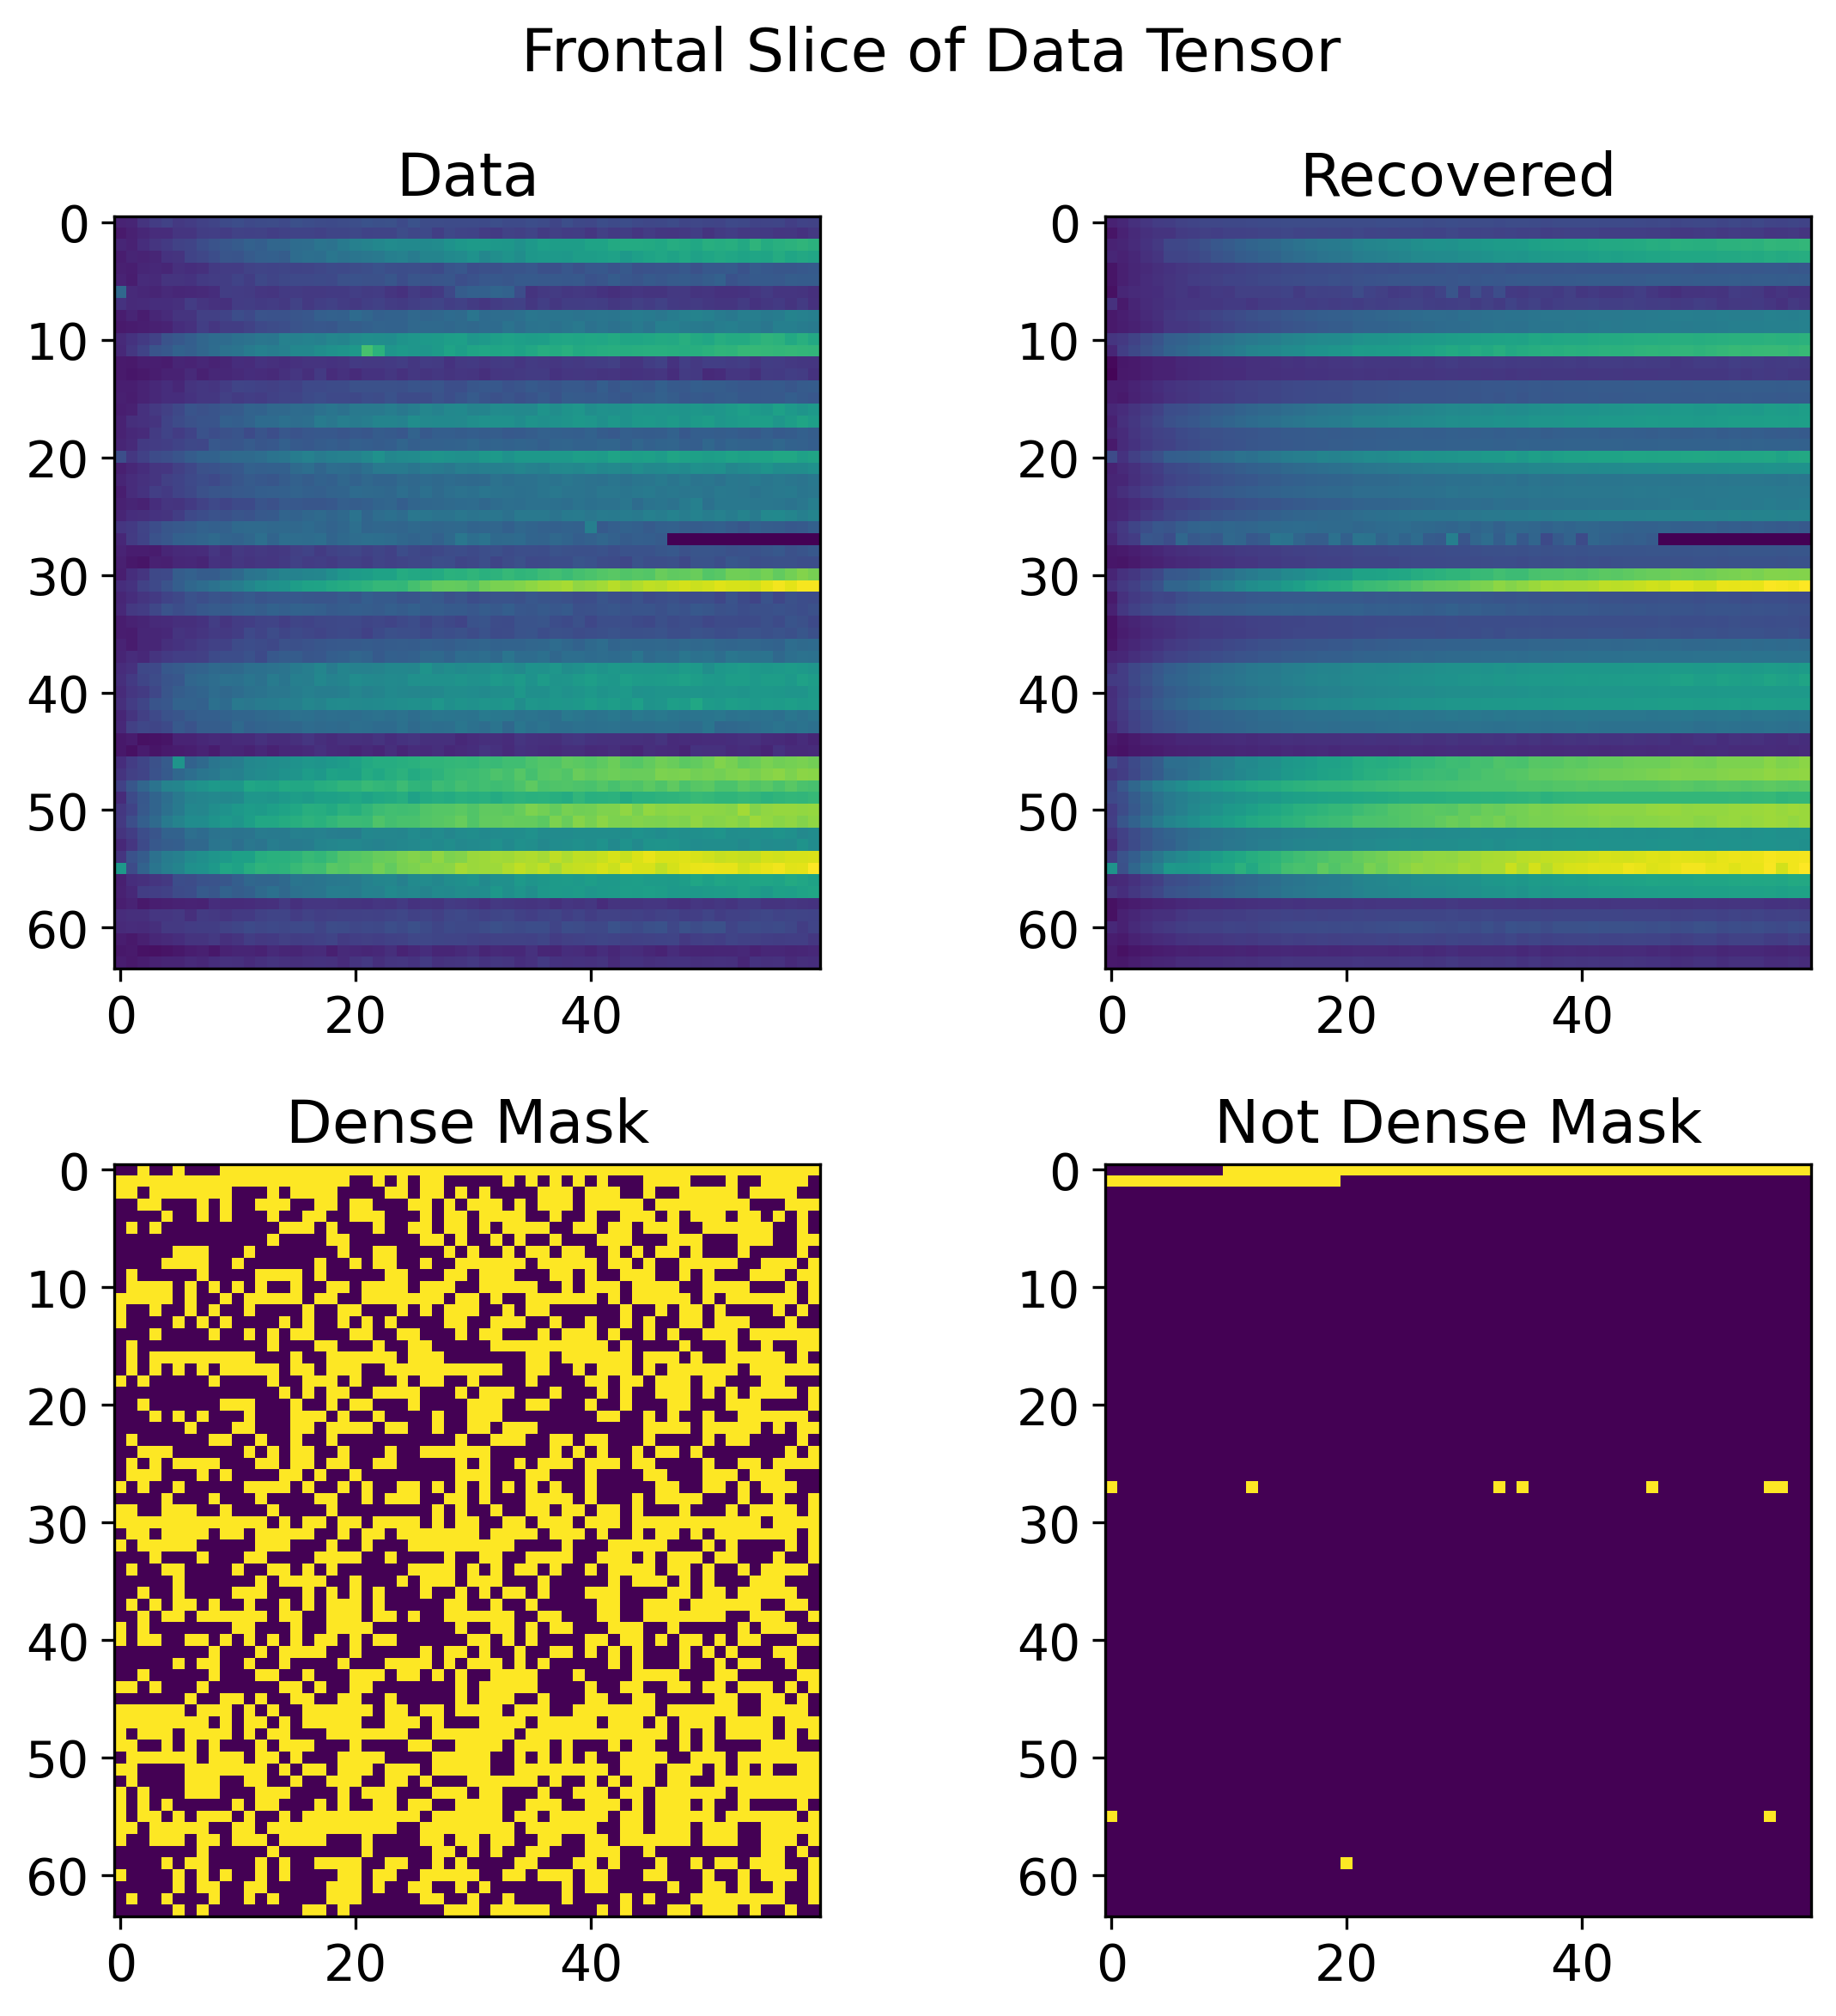

In [16]:
display_results(result_inner_als,data,real_mask=real_mask)

In [44]:
with open('result_adaptive.pickle', 'wb') as f:
    pickle.dump(result_adaptive, f)

with open('result_nonadaptive.pickle', 'wb') as f:
    pickle.dump(result_nonadaptive, f)
    
with open('result_inner_als.pickle', 'wb') as f:
    pickle.dump(result_inner_als, f)



Let's load some more of this fluorence type data

In [17]:
mat = scipy.io.loadmat('data/fluordata.mat',simplify_cells=True)
fluor = mat['fluor']['data']

emission_ticks = mat['fluor']['axisscale'][1][0]
excite_ticks =  mat['fluor']['axisscale'][2][0]
class_set = mat['fluor']['class'][0][0][1]
type_set = mat['fluor']['class'][0][0][0]

print("Shape of the fluor data: ", fluor.shape)

Shape of the fluor data:  (405, 136, 19, 5)


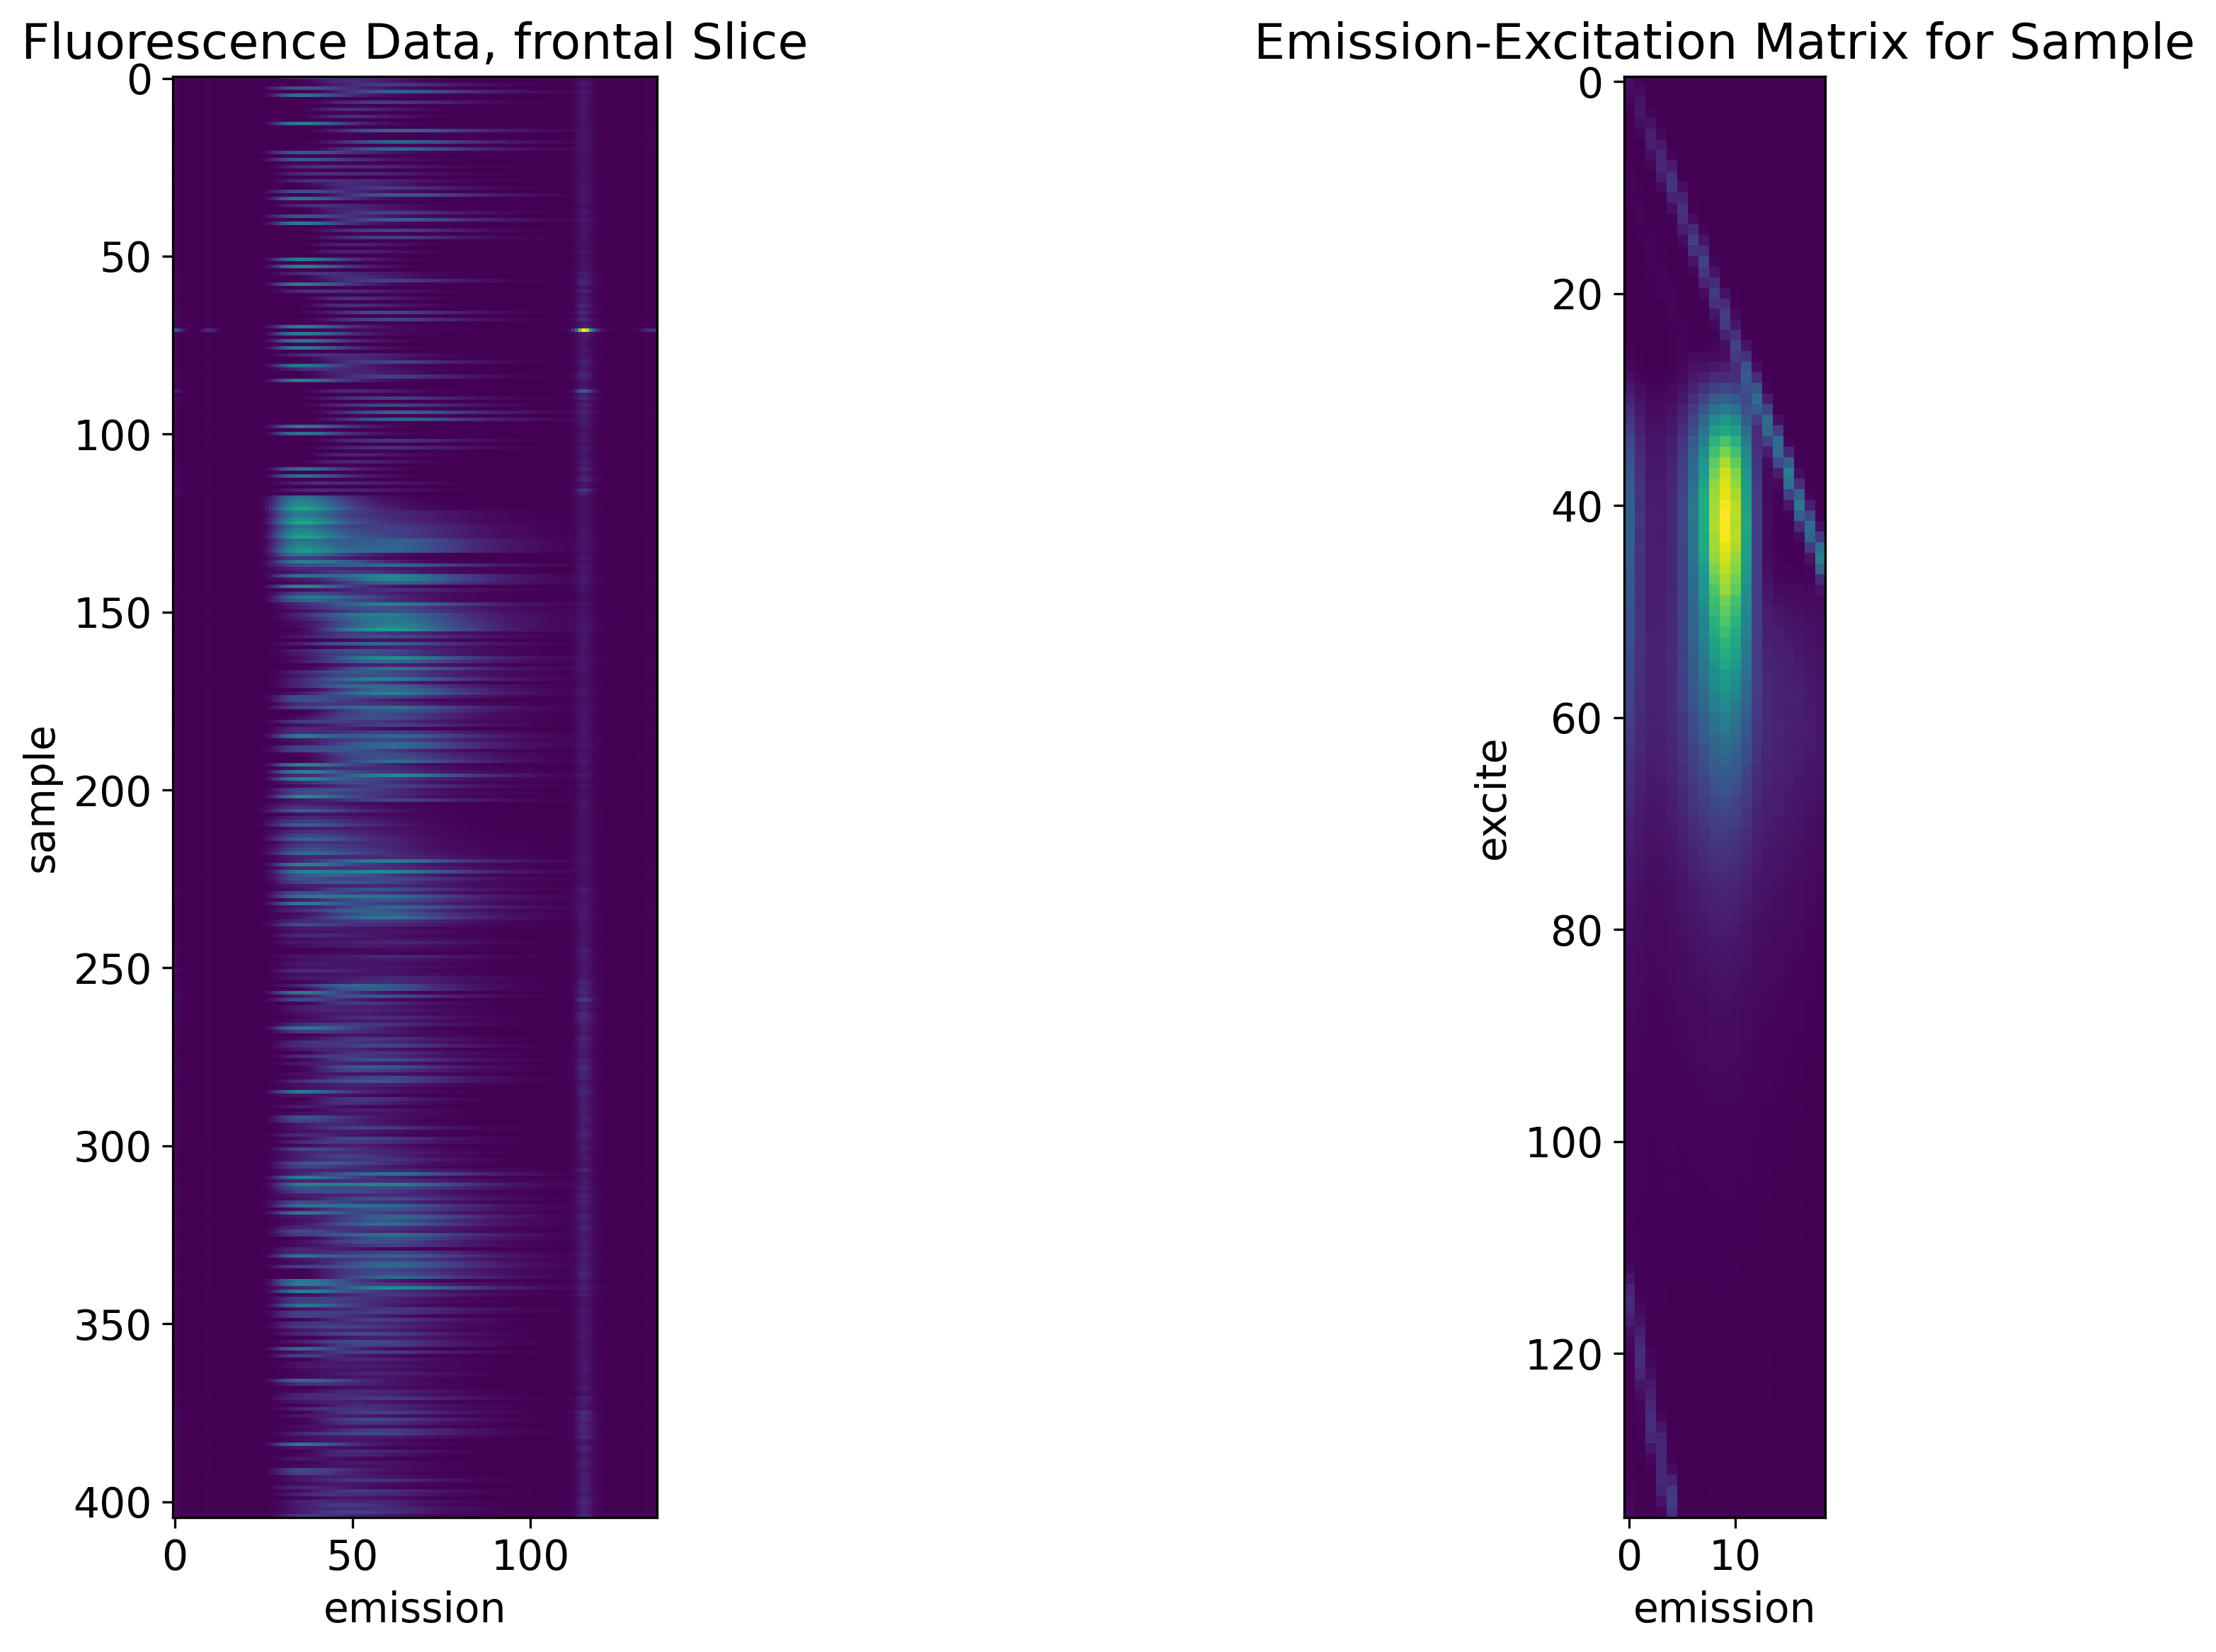

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
ax[0].set_title("Fluorescence Data, frontal Slice")
plt.imshow(fluor[:,:,0,0])
plt.xlabel("emission")
plt.ylabel("sample")

plt.subplot(1,2,2)
ax[1].set_title("Emission-Excitation Matrix for Sample")
plt.imshow(fluor[0,:,:,0])
plt.xlabel("emission")
plt.ylabel("excite")

plt.tight_layout()
plt.show()


Data has replicates along the fourth mode. So its not really new info. Let's just do it on three modes

In [25]:
data = fluor
data = data[:,:,:,0]

In [26]:
r=19
n_slices = 4
alpha=1
beta = 0.5
delta = 8
gamma = 0.5
relnoise = 0
result_bigflour_adaptive = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,adaptive=True,full_output=True)
result_bigflour_nonadaptive = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,adaptive=False,full_output=True)

Selected slices: [ 6  2 11 17]
Completing slice:  6
Sample size:  27540
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:21:55 PM: Your problem has 55080 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:21:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:21:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:21:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:21:55 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:21:5

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completing slice:  2
Sample size:  27540
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:30:38 PM: Your problem has 55080 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:30:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:30:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:30:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:30:38 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:30:38 PM: Reduction chain: Dcp2Cone

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completing slice:  11
Sample size:  27540
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:39:18 PM: Your problem has 55080 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:39:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:39:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:39:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:39:18 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:39:18 PM: Reduction chain: Dcp2Con

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Selected slices: [ 3 18 15  0]
Completing slice:  3
Sample size:  27540
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 27 06:54:26 PM: Your problem has 55080 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 27 06:54:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 27 06:54:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 27 06:54:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 27 06:54:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 27 06:54:2

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(CVXPY) Sep 27 07:02:58 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Sep 27 07:02:59 PM: Applying reduction SCS
(CVXPY) Sep 27 07:02:59 PM: Finished problem compilation (took 6.908e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 27 07:02:59 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 201691, constraints m: 311851
cones: 	  l: linear vars: 165240
	  s: psd vars: 146611, ssize: 1
settings: eps_abs: 1.0e-08, eps_rel: 1.0e-08, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 10000, nor

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(CVXPY) Sep 27 07:14:25 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Sep 27 07:14:25 PM: Applying reduction SCS
(CVXPY) Sep 27 07:14:25 PM: Finished problem compilation (took 6.923e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 27 07:14:25 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 201691, constraints m: 311851
cones: 	  l: linear vars: 165240
	  s: psd vars: 146611, ssize: 1
settings: eps_abs: 1.0e-08, eps_rel: 1.0e-08, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 10000, nor

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# Adaptive - Fluor, 3-mode

Rel Error 	 Matrix Slice Sample Size 	 Total Samples 	 Prop Revealed
0.251547 	 27540 	 112717 	 0.107706 
sample counts in slices :,:,i,0  [  152   152 27616   152   152   152 27626   152   152   152   152 27623
   152   152   152   152   152 27572   152]
errors in slices :,:,i,0  [0.42200002 0.35268502 0.22365961 0.31780521 0.22845376 0.12046482
 0.04243637 0.08705606 0.13635933 0.15437734 0.15141238 0.16355316
 0.37819742 0.57496075 0.75606287 1.48921042 2.59051932 0.48392662
 1.0305562 ]


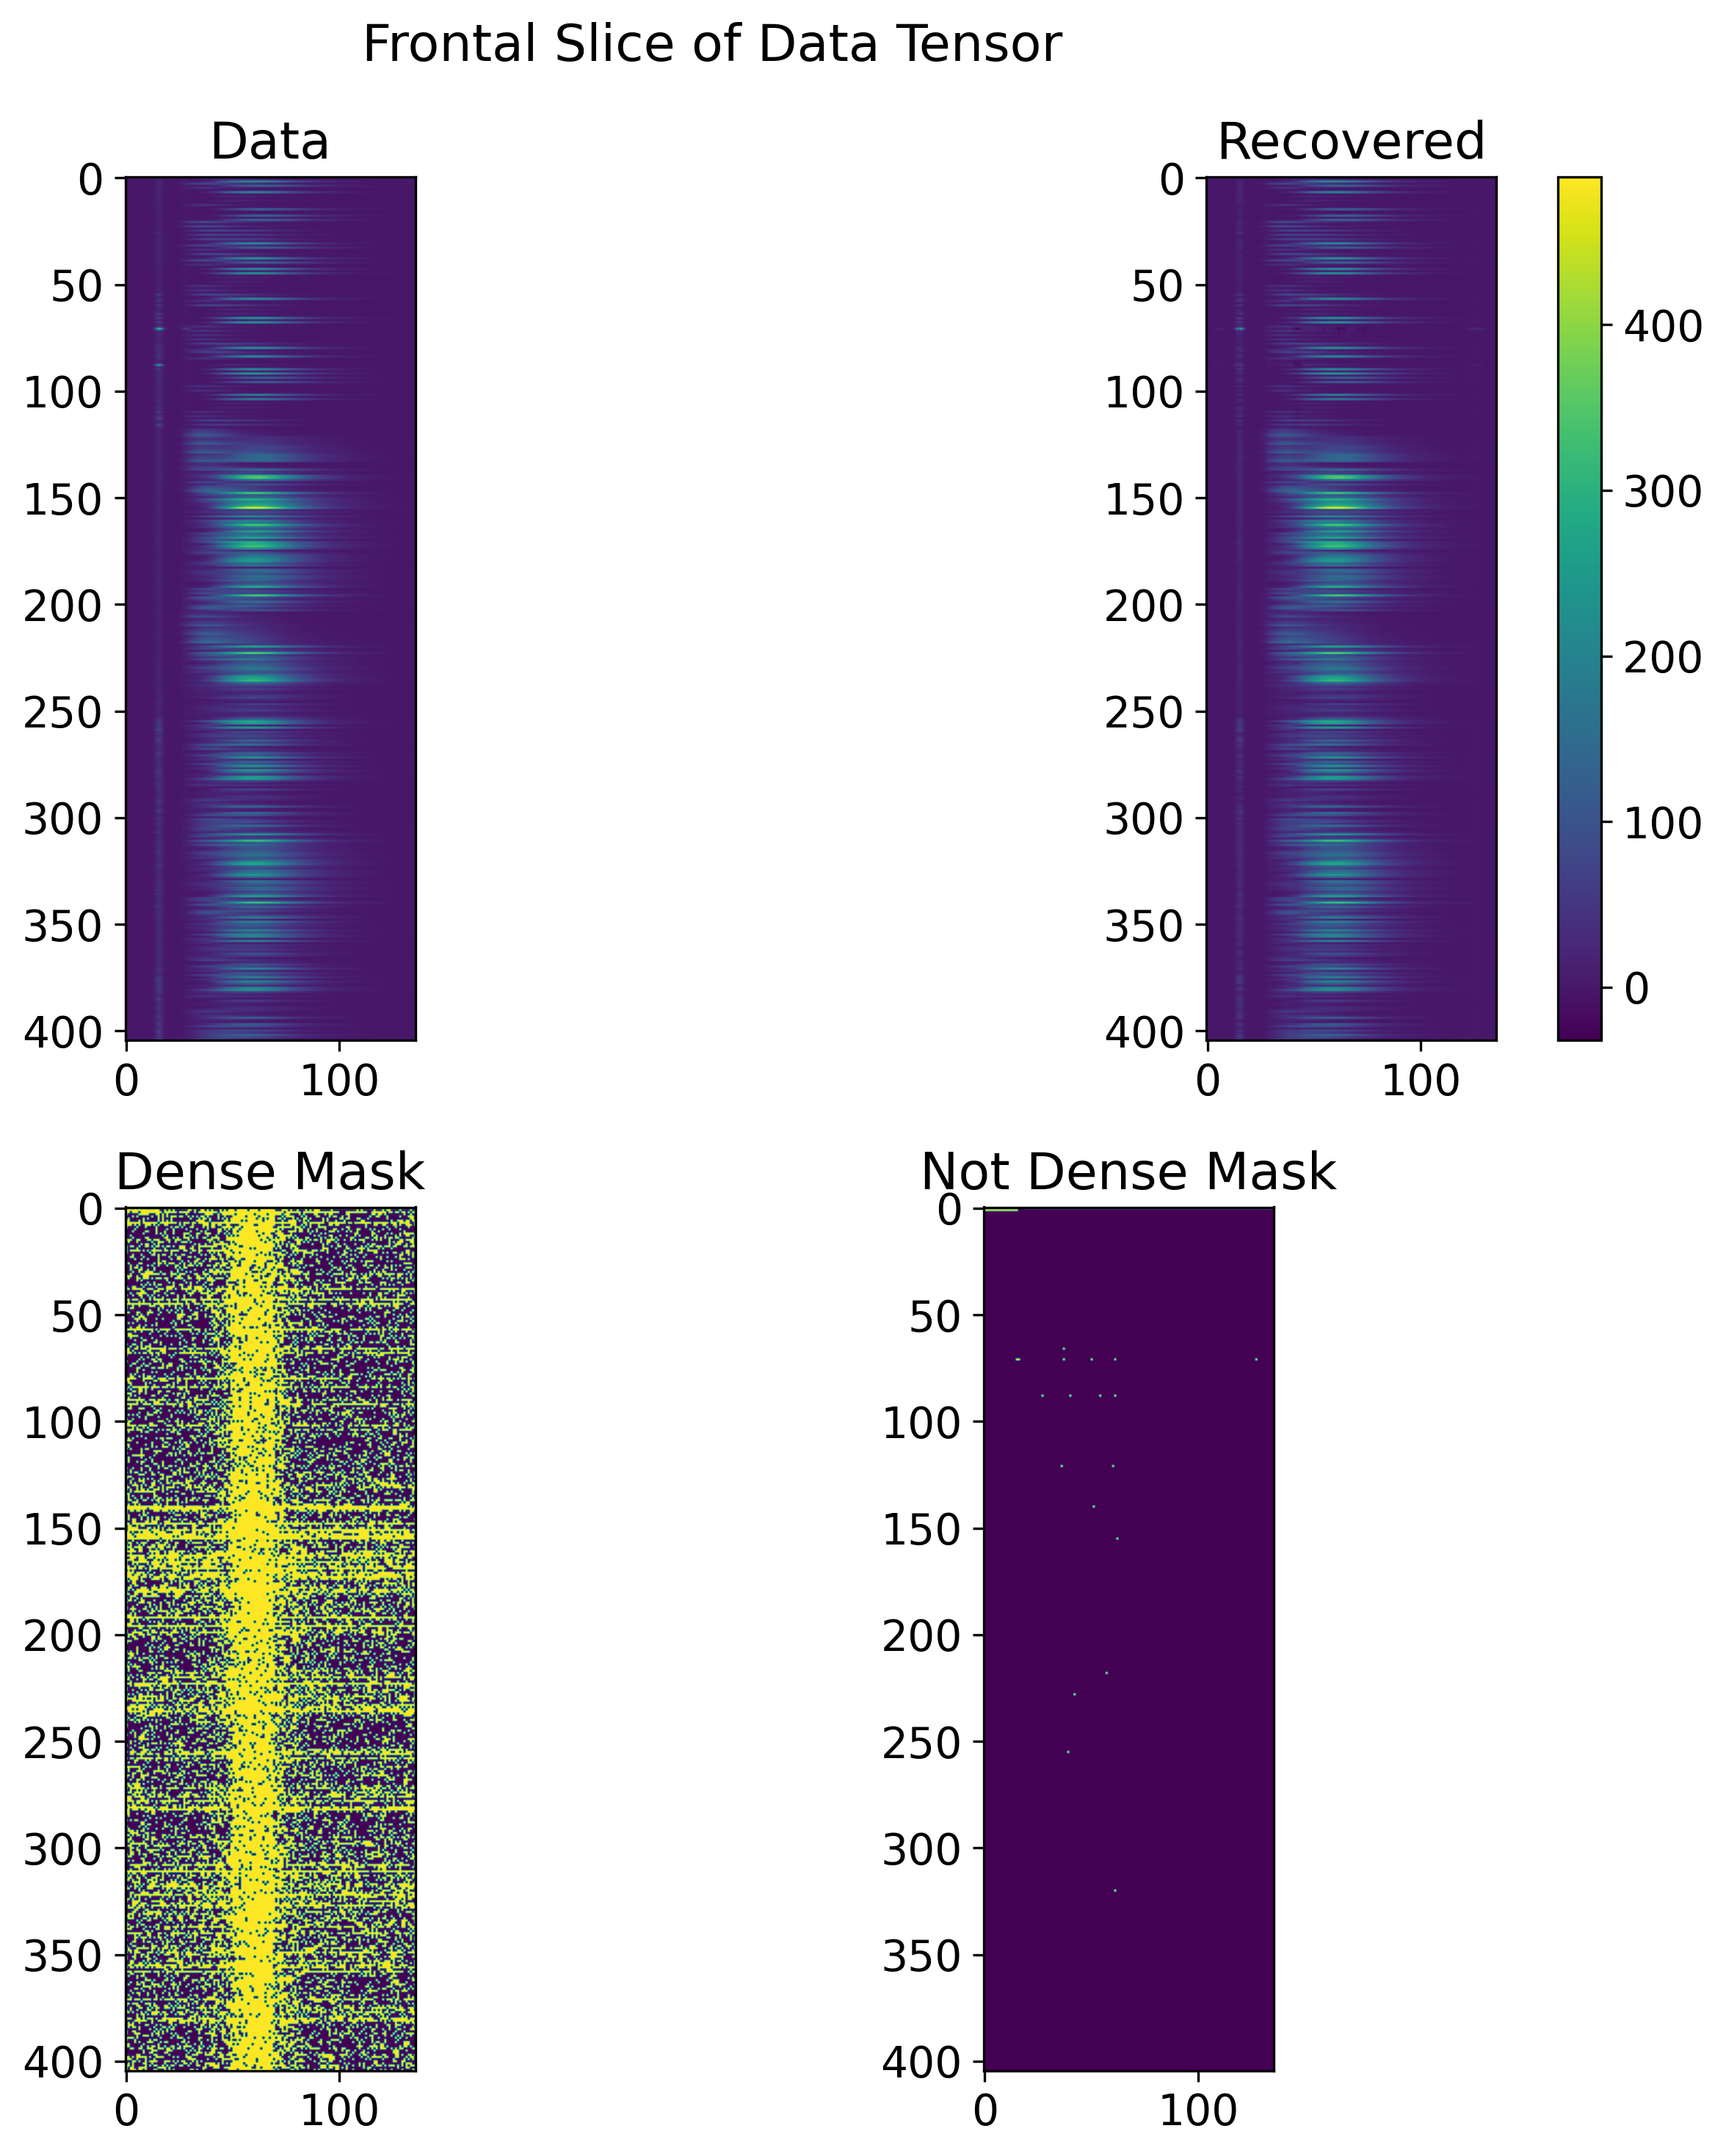

In [40]:
display_results(result_bigflour_adaptive,data)

# Non-adaptive - Fluor, 3-mode

Rel Error 	 Matrix Slice Sample Size 	 Total Samples 	 Prop Revealed
0.420521 	 27540 	 112742 	 0.107730 
sample counts in slices :,:,i,0  [27598   166   143 27612   161   142   162   142   158   162   159   147
   140   187   165 27622   132   131 27613]
errors in slices :,:,i,0  [0.19776231 0.37124917 0.78923813 0.29893022 0.36822775 0.42475246
 0.40314485 0.37606302 0.36732197 0.39754866 0.62164814 0.33554611
 0.32799124 0.37521867 0.34612983 0.4283999  0.9376609  0.85289302
 0.302749  ]


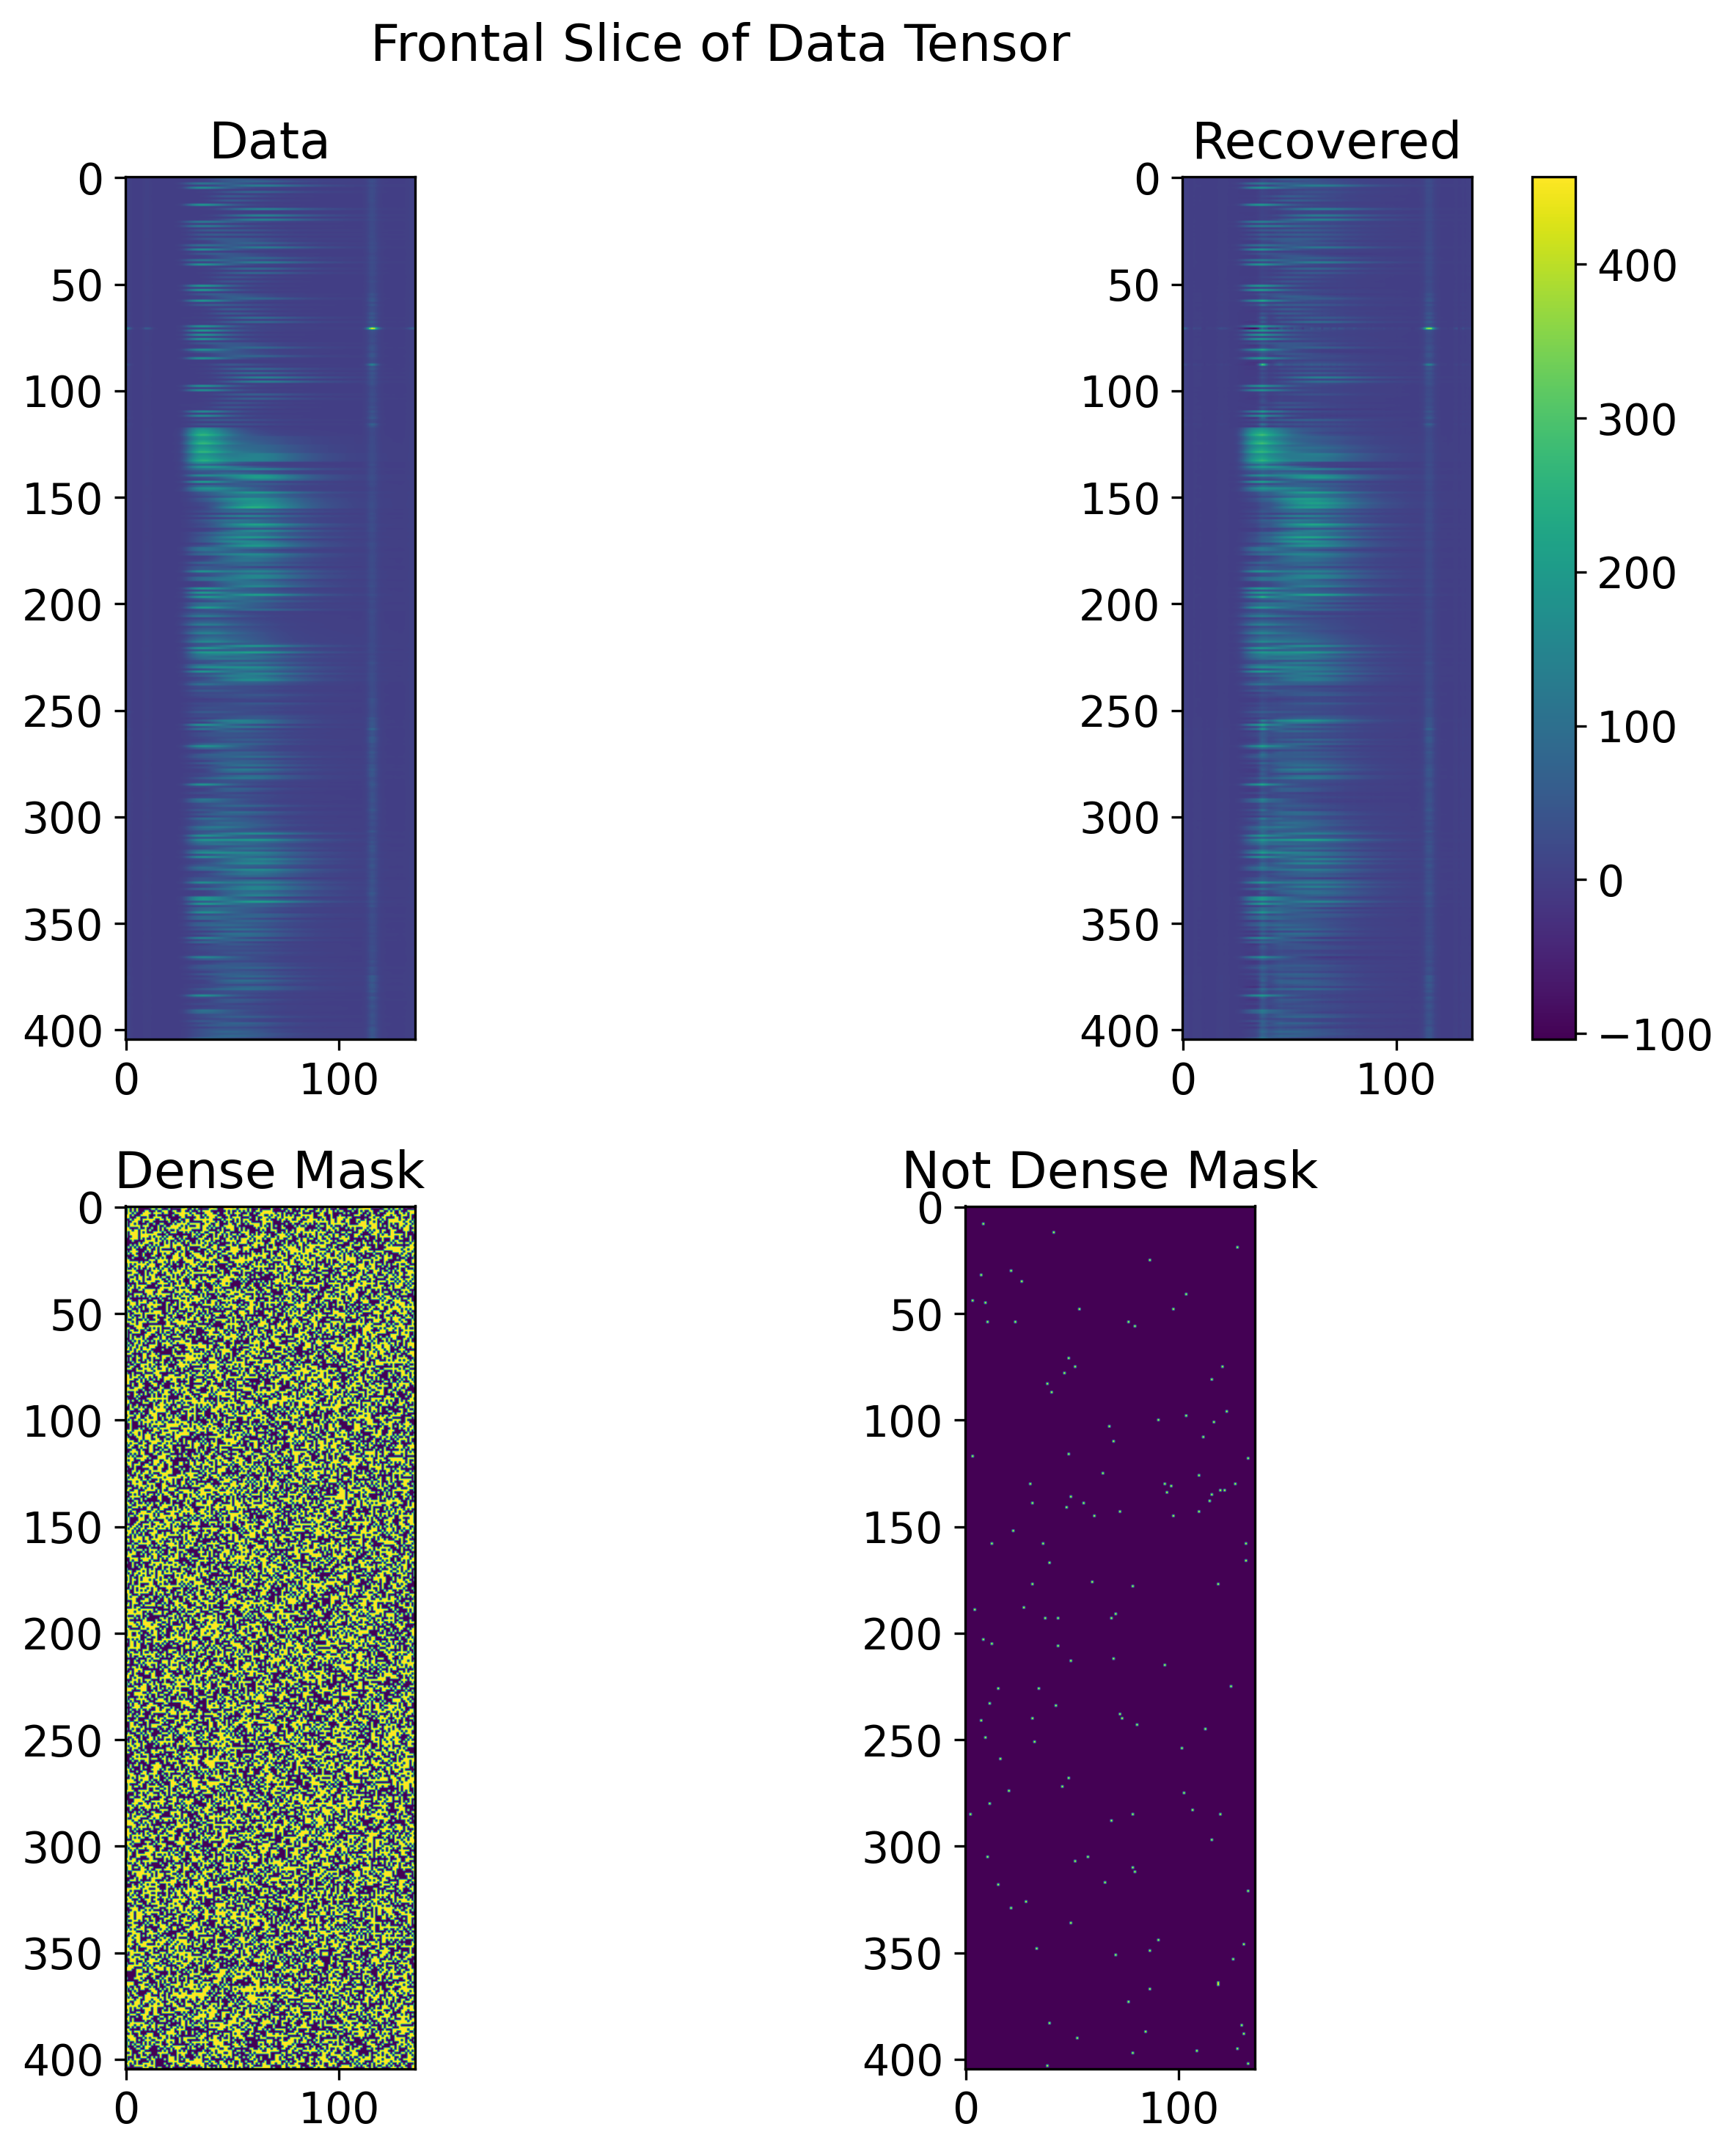

In [41]:
display_results(result_bigflour_nonadaptive,data)

In [45]:
with open('result_bigflour_adaptive.pickle', 'wb') as f:
    pickle.dump(result_bigflour_adaptive, f)

with open('result_bigflour_nonadaptive.pickle', 'wb') as f:
    pickle.dump(result_bigflour_nonadaptive, f)
    

Here's a view of an EEM matrix from the data, could you use the recovered EEM to ID the sample? Probably!

sample counts in slices :,:,i,0  [2253  511  341  220  256  203  213  325  226  247  205  220  225  217
  221  298  220  197  257  215  274  213  213  201  199  275  189  296
  209  277  232  314  209  285  216  213  196  231  339  219  272  201
  209  342  200  316  219  222  210  228  229  216  204  197  201  272
  227  334  219  224  262  196  247  201  219  208  398  212  341  213
  215  460  215  205  198  203  225  210  291  241  347  225  212  213
  331  210  200  272  394  203  320  216  345  225  281  210  275  201
  209  217  214  212  282  188  295  223  235  204  240  189  233  206
  233  245  261  210  286  193  219  210  194  254  205  201  216  222
  245  239  229  251  287  295  279  295  209  220  220  268  227  271
  425  405  298  223  240  295  331  318  495  326  284  498  399  386
  436  465  237  312  214  408  210  383  364  430  342  279  378  356
  358  478  346  464  367  460  312  220  330  299  343  359  395  309
  307  218  242  269  281  311  281  296  26

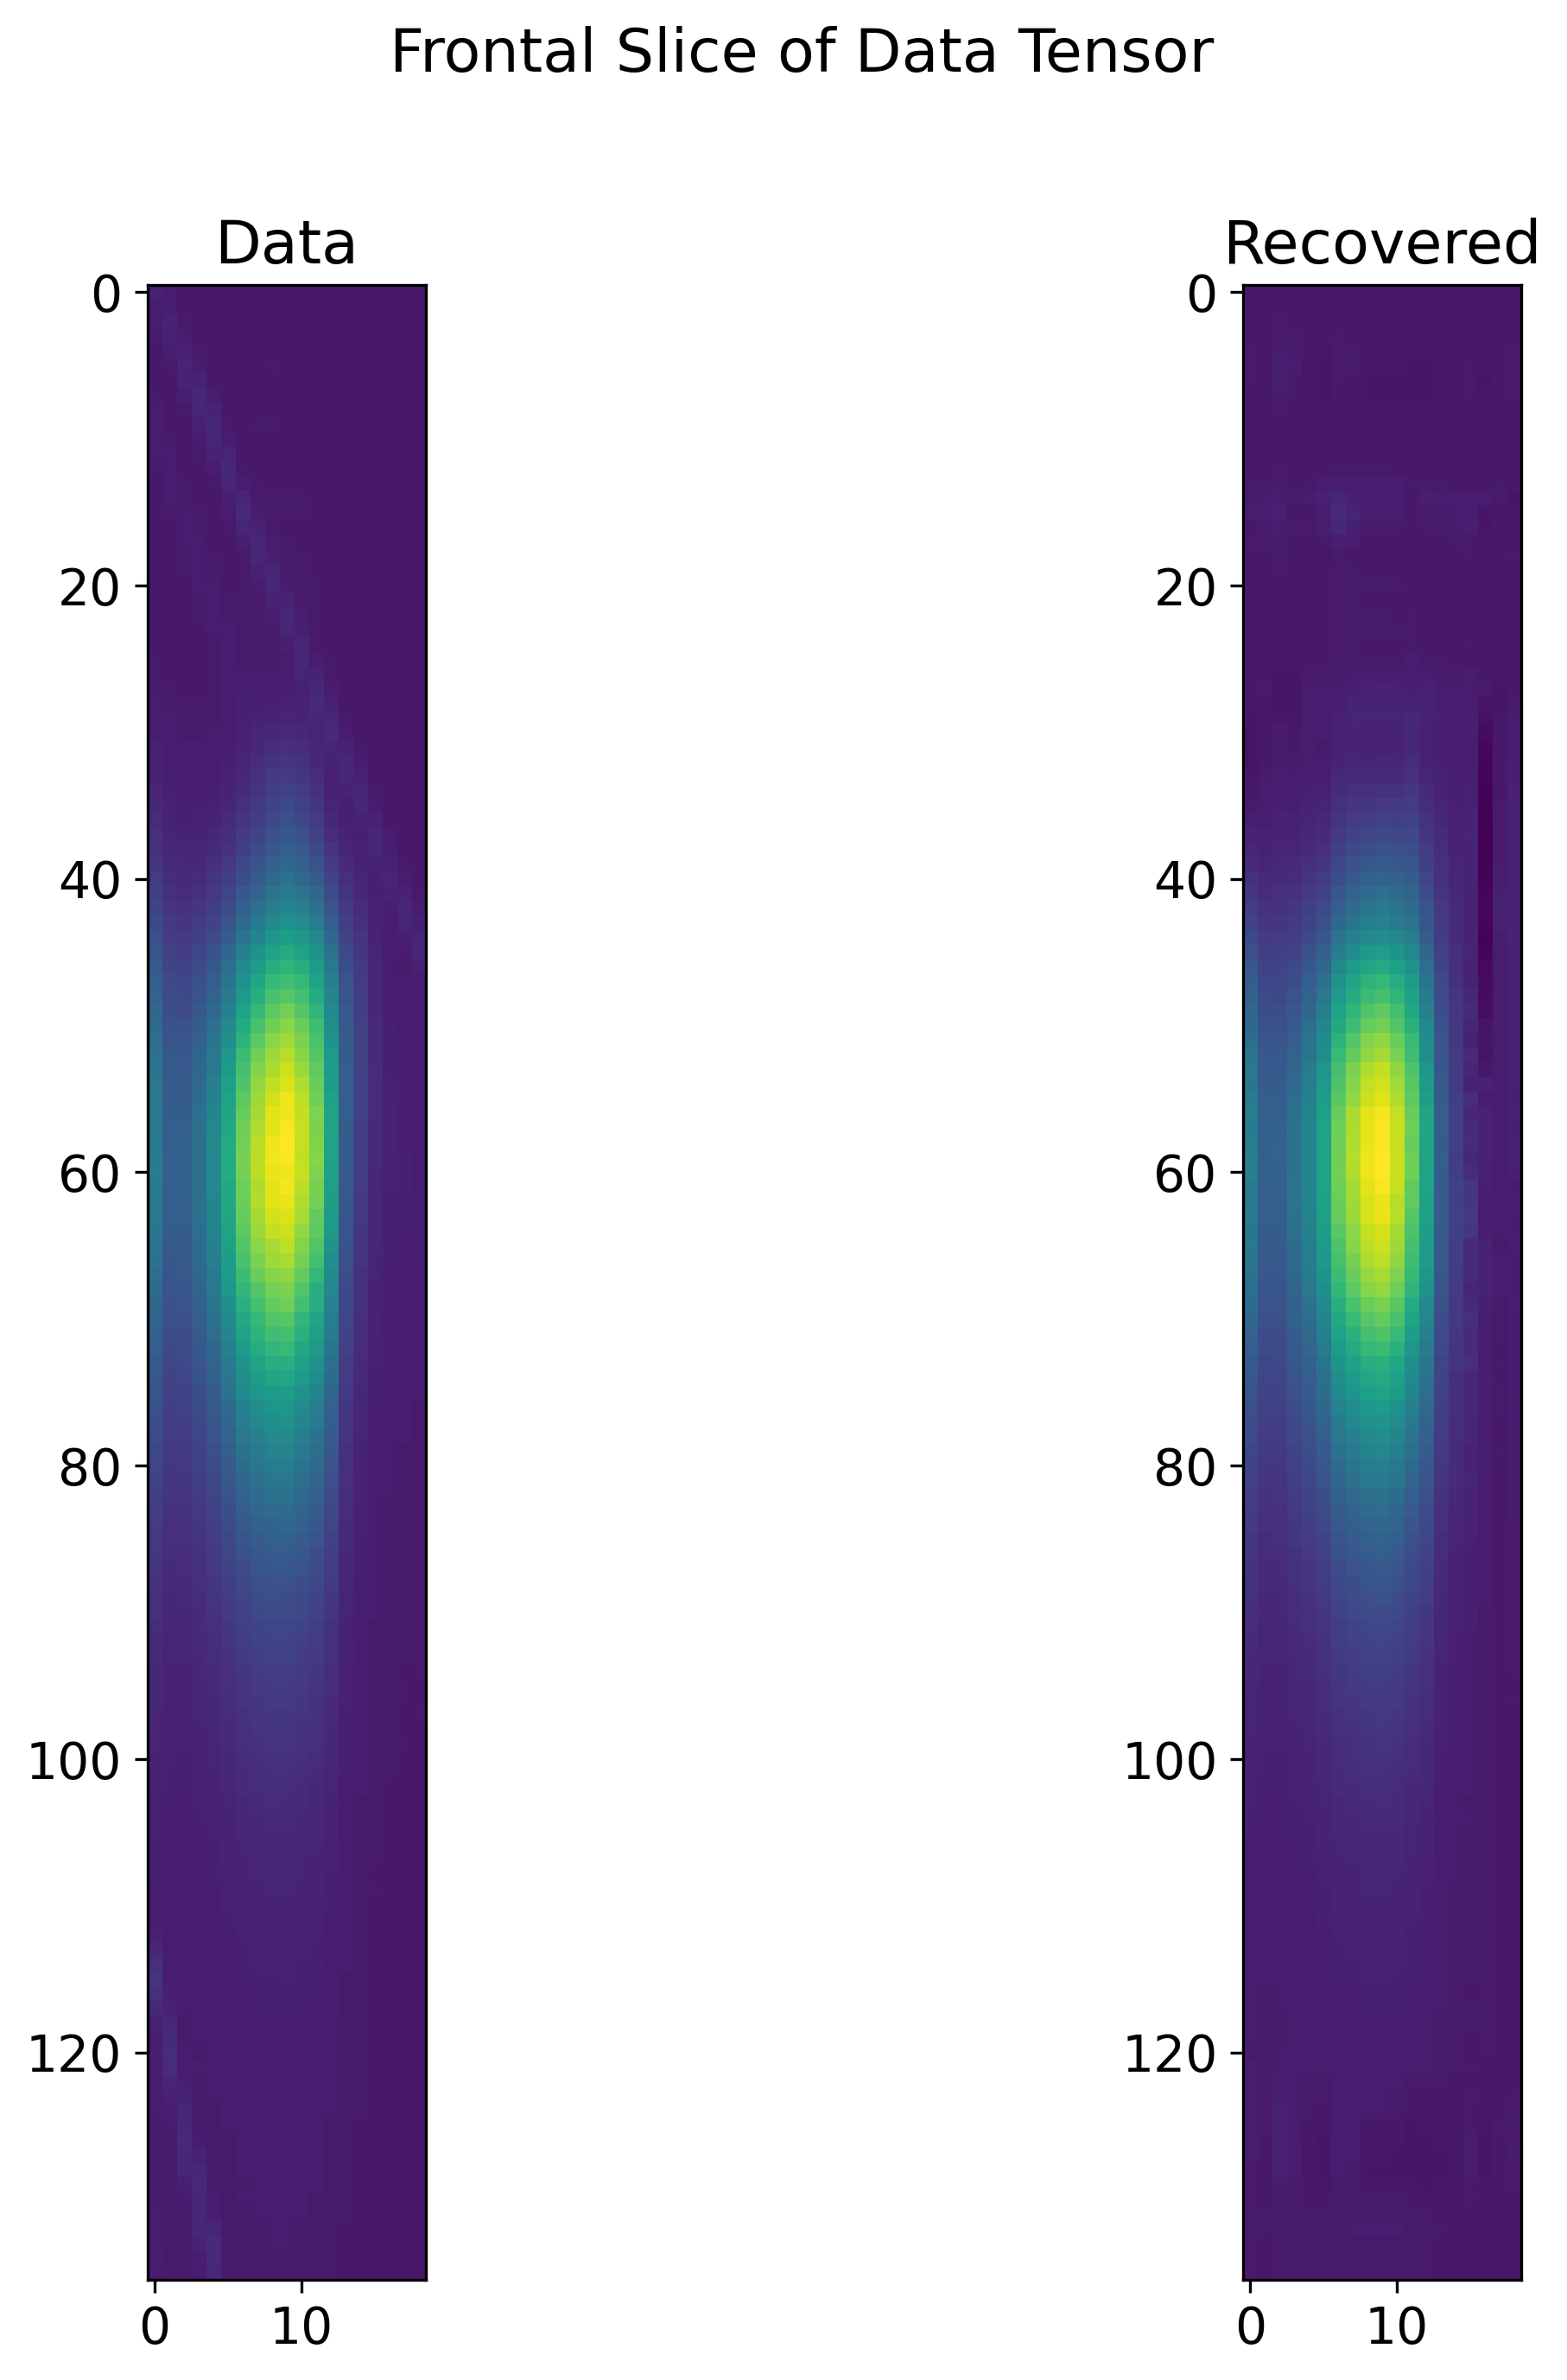

In [51]:

recovered_tensor = tl.cp_tensor.CPTensor((result_bigflour_adaptive[4][0],result_bigflour_adaptive[4][1]))
full_recovered_tensor = np.real(tl.cp_to_tensor(recovered_tensor))
N = full_recovered_tensor.shape
d = len(N)
      
        
sub_tensor3_idx = [list(range(N[0])),list(range(N[1])),list(range(N[2]))] + [[0] for _ in range(d-3)]
               
slice_sample_counts = np.sum(result_bigflour_adaptive[5][np.ix_(*sub_tensor3_idx)],axis=(1,2))
slice_rel_errors = np.linalg.norm(full_recovered_tensor[np.ix_(*sub_tensor3_idx)] - data[np.ix_(*sub_tensor3_idx)], axis=(1,2)) / np.linalg.norm(data[np.ix_(*sub_tensor3_idx)], axis=(1,2))

print("sample counts in slices :,:,i,0 ", slice_sample_counts)
print("errors in slices :,:,i,0 ", slice_rel_errors)
    
    

my_slice = np.argmin(slice_rel_errors)


print(tl.norm(np.real(full_recovered_tensor - data) / tl.norm(data)))
# Set up figure and image grid

fig,ax = plt.subplots(1,2,figsize=(10,10))
    
sub_tensor3_idx[0] = [np.argmin(slice_rel_errors)]
    
resultant = np.array([full_recovered_tensor[np.ix_(*sub_tensor3_idx)], data[np.ix_(*sub_tensor3_idx)]])
min_val, max_val = np.amin(resultant), np.amax(resultant)
    
fig.suptitle("Frontal Slice of Data Tensor")
plt.subplot(1,2,1)
plt.title("Data")

ax[0].imshow(np.squeeze( data[np.ix_(*sub_tensor3_idx)]),vmin=min_val, vmax=max_val)

plt.subplot(1,2,2)
plt.title("Recovered")
im = ax[1].imshow(np.squeeze( full_recovered_tensor[np.ix_(*sub_tensor3_idx)]), vmin=min_val, vmax=max_val)
    
plt.show()

Shape of the data:  (145, 145, 200)


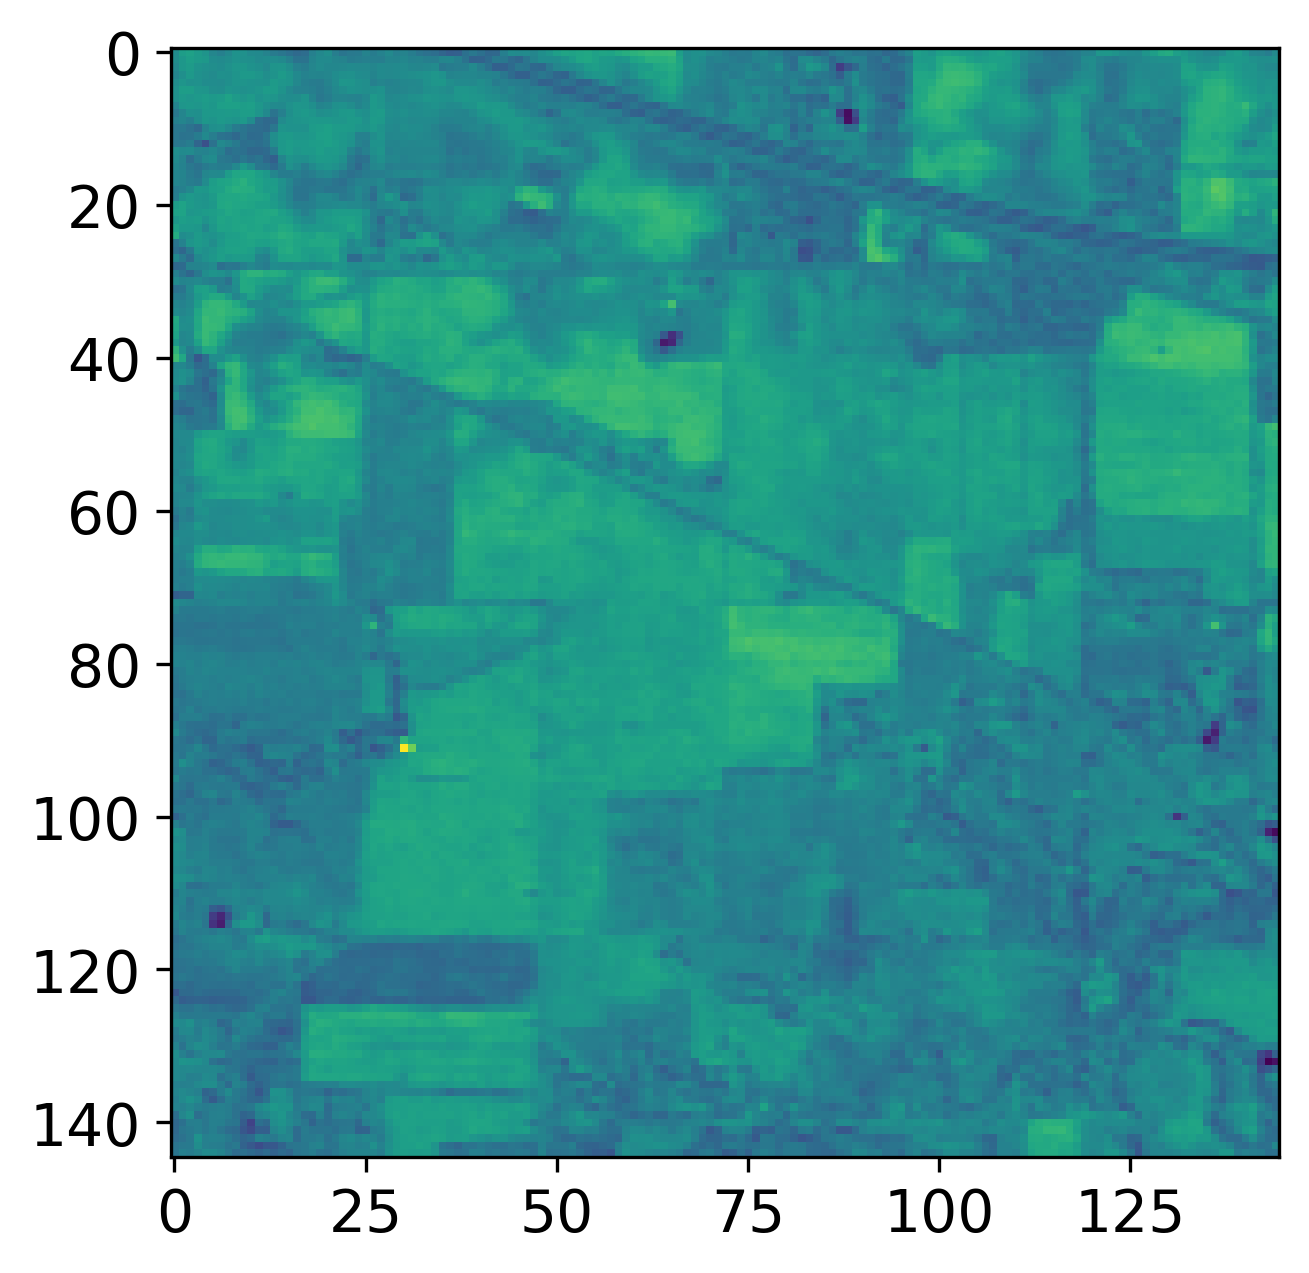

In [52]:
mat = scipy.io.loadmat('data/Indian_pines_corrected.mat',simplify_cells=True)
data = mat['indian_pines_corrected']

#Let's normalize and center the data, also should be floats instead of ints, which this also accomplishes

data = data / np.max(data)
data = data - np.mean(data)
print("Shape of the data: ", data.shape)
plt.imshow(data[:,:,100])

In [132]:
r=60
n_slices = 8
alpha=1
beta = 0.5
delta = 10
gamma = 0.6
relnoise = 0
result = ts.tensor_deli(data,data,r,relnoise,n_slices,alpha,beta,delta,gamma,full_output=True)

Selected slices: [187 174 119 118  91  27  73  20  86 120]
Completing slice:  187
Sample size:  12616
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 25 06:33:00 PM: Your problem has 21025 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 25 06:33:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 25 06:33:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 25 06:33:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 25 06:33:00 PM: Compiling problem (target solve

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(CVXPY) Sep 25 06:38:41 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Sep 25 06:38:41 PM: Applying reduction SCS
(CVXPY) Sep 25 06:38:42 PM: Finished problem compilation (took 2.565e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 25 06:38:42 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 63220, constraints m: 105270
cones: 	  l: linear vars: 63075
	  s: psd vars: 42195, ssize: 1
settings: eps_abs: 1.0e-08, eps_rel: 1.0e-08, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 10000, normal

/mnt/home/haselbyc/anaconda3/envs/sand/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(CVXPY) Sep 25 06:42:55 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Sep 25 06:42:55 PM: Applying reduction SCS
(CVXPY) Sep 25 06:42:55 PM: Finished problem compilation (took 2.919e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 25 06:42:55 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 63220, constraints m: 105270
cones: 	  l: linear vars: 63075
	  s: psd vars: 42195, ssize: 1
settings: eps_abs: 1.0e-08, eps_rel: 1.0e-08, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 10000, normal

In [134]:
recovered_factors = [np.copy(result[4][1][i]) for i in range(3)]
recovered_weights = np.copy(result[4][0])

recovered_tensor = tl.cp_tensor.CPTensor((recovered_weights,recovered_factors))
full_recovered_tensor = np.real(tl.cp_to_tensor(recovered_tensor))

slice_sample_counts = np.sum(result[5][:,:,:],axis=(0,1))
slice_rel_errors = np.linalg.norm(full_recovered_tensor[:,:,:] - data[:,:,:], axis=(0,1)) / np.linalg.norm(data[:,:,:], axis=(0,1))

print("sample counts in slices :,:,i ", slice_sample_counts)
print("errors in slices :,:,i ", slice_rel_errors)

sample counts in slices :,:,i  [  600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600 12829   600   600   600
   600   600   600 12835   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600 12886   600   600   600   600   600   600   600   600   600   600
   600   600 12867   600   600   600   600 12882   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600 12863 12864
 12863   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600   600   600   600   600   600   600   600   600   600
   600   600   600  

In [135]:
init_recovered_factors = [np.copy(result[4][1][i]) for i in range(3)]
init_recovered_weights = np.copy(result[4][0])

post_als = parafac(data,60,init=(init_recovered_weights, init_recovered_factors),n_iter_max = 10,mask=result[5],verbose=1)

reconstruction error=0.027059441989522547
iteration 1, reconstruction error: 0.024538759173691388, decrease = 0.0025206828158311594, unnormalized = 8.296825520358828
iteration 2, reconstruction error: 0.02364513914733753, decrease = 0.0008936200263538578, unnormalized = 7.994830775653063
iteration 3, reconstruction error: 0.02307110985242708, decrease = 0.0005740292949104504, unnormalized = 7.800866293960276
iteration 4, reconstruction error: 0.022649518269023543, decrease = 0.0004215915834035362, unnormalized = 7.658426434994741
iteration 5, reconstruction error: 0.022314107225573438, decrease = 0.00033541104345010536, unnormalized = 7.545114998462643
iteration 6, reconstruction error: 0.02203325127719107, decrease = 0.00028085594838236916, unnormalized = 7.450242321742361
iteration 7, reconstruction error: 0.02179009989475012, decrease = 0.00024315138244094744, unnormalized = 7.368112833427196
iteration 8, reconstruction error: 0.021574870969715162, decrease = 0.0002152289250349597, 

In [139]:
size = data.size
n_samples = result[2]
just_als_mask = np.zeros(size)
just_als_mask[:n_samples] = 1
np.random.shuffle(just_als_mask)
just_als_mask = just_als_mask.reshape(data.shape)

just_als = parafac(data,60,n_iter_max = 10,mask=just_als_mask,verbose=1)

reconstruction error=0.05848761665379745
iteration 1, reconstruction error: 0.05586148220131691, decrease = 0.0026261344524805413, unnormalized = 18.484686801356116
iteration 2, reconstruction error: 0.05305649703340736, decrease = 0.0028049851679095503, unnormalized = 17.560854826522085
iteration 3, reconstruction error: 0.05038937357634941, decrease = 0.0026671234570579544, unnormalized = 16.684050248599068
iteration 4, reconstruction error: 0.04792320113465481, decrease = 0.0024661724416946, unnormalized = 15.874538982237558
iteration 5, reconstruction error: 0.04566813182187467, decrease = 0.0022550693127801336, unnormalized = 15.135230427998495
iteration 6, reconstruction error: 0.04361639942159488, decrease = 0.002051732400279796, unnormalized = 14.46324688927237
iteration 7, reconstruction error: 0.04175390517921816, decrease = 0.0018624942423767152, unnormalized = 13.853723075416305
iteration 8, reconstruction error: 0.04006462262168647, decrease = 0.0016892825575316947, unnorm

[0.3534498810881149, 12615, 242613, 0.057696313912009516]
Deli Rel Error:  0.3534498810881149
Deli + ALS Rel Error:  0.10678603575673452
Just ALS Rel Error:  0.17732759872933812


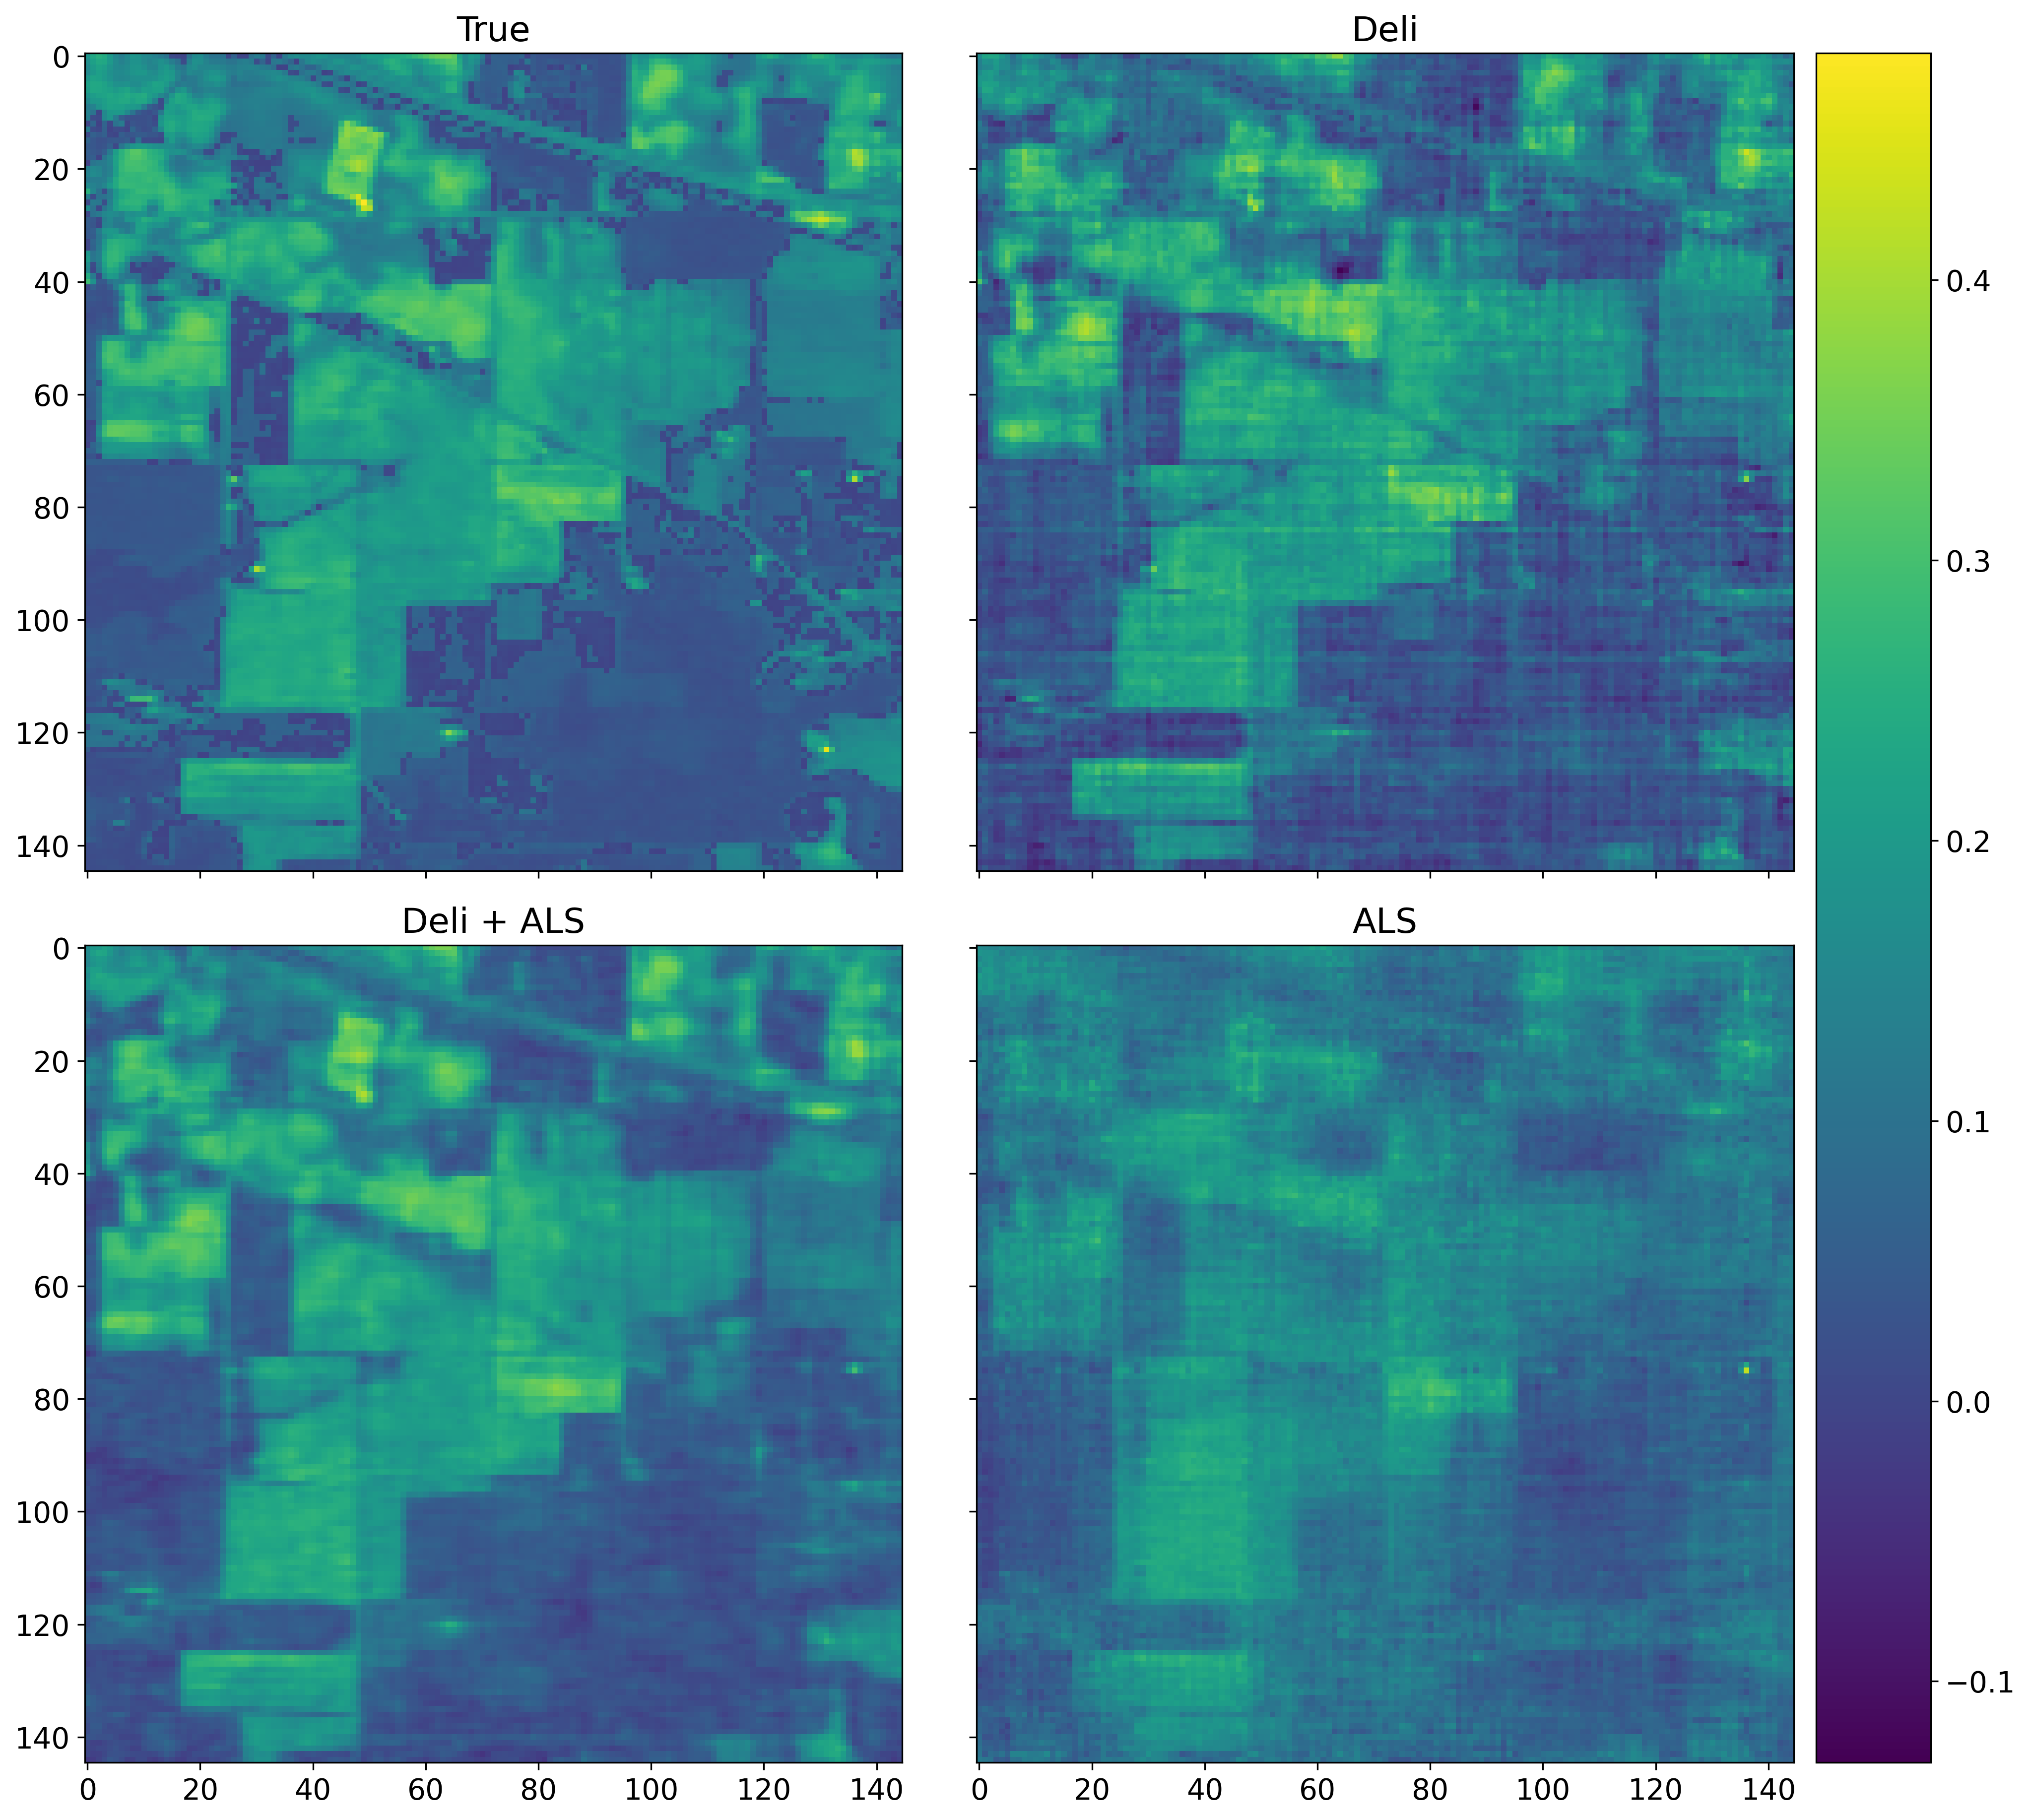

In [150]:
my_slice = np.argmin(slice_rel_errors)

full_recovered_tensor_als = np.real(tl.cp_to_tensor(post_als))

full_recovered_tensor_just_als = np.real(tl.cp_to_tensor(just_als))

print(result[:4])

print("Deli Rel Error: ", tl.norm(np.real(full_recovered_tensor - data) / tl.norm(data)))
print("Deli + ALS Rel Error: ", tl.norm(np.real(full_recovered_tensor_als - data) / tl.norm(data)))
print("Just ALS Rel Error: ", tl.norm(np.real(full_recovered_tensor_just_als - data) / tl.norm(data)))

# Set up figure and image grid
fig = plt.figure(figsize=(16,16))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,2),
                 axes_pad=0.5,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid

resultant = np.array([full_recovered_tensor[:,:,my_slice], data[:,:,my_slice], full_recovered_tensor_als[:,:,my_slice]])
min_val, max_val = np.amin(resultant), np.amax(resultant)
im = grid[2].imshow(np.real(full_recovered_tensor_als[:,:,my_slice]), vmin=min_val, vmax=max_val)
im = grid[1].imshow(np.real(full_recovered_tensor[:,:,my_slice]), vmin=min_val, vmax=max_val)
im = grid[0].imshow(data[:,:,my_slice], vmin=min_val, vmax=max_val)
im = grid[3].imshow(full_recovered_tensor_just_als[:,:,my_slice], vmin=min_val, vmax=max_val)
# Colorbar
grid[1].cax.colorbar(im)
grid[1].cax.toggle_label(True)

grid[0].set_title('True')

grid[1].set_title('Deli')

grid[2].set_title('Deli + ALS')
                  
grid[3].set_title('ALS')
                  
plt.show()


In [152]:
slice_sample_counts[my_slice]

12829

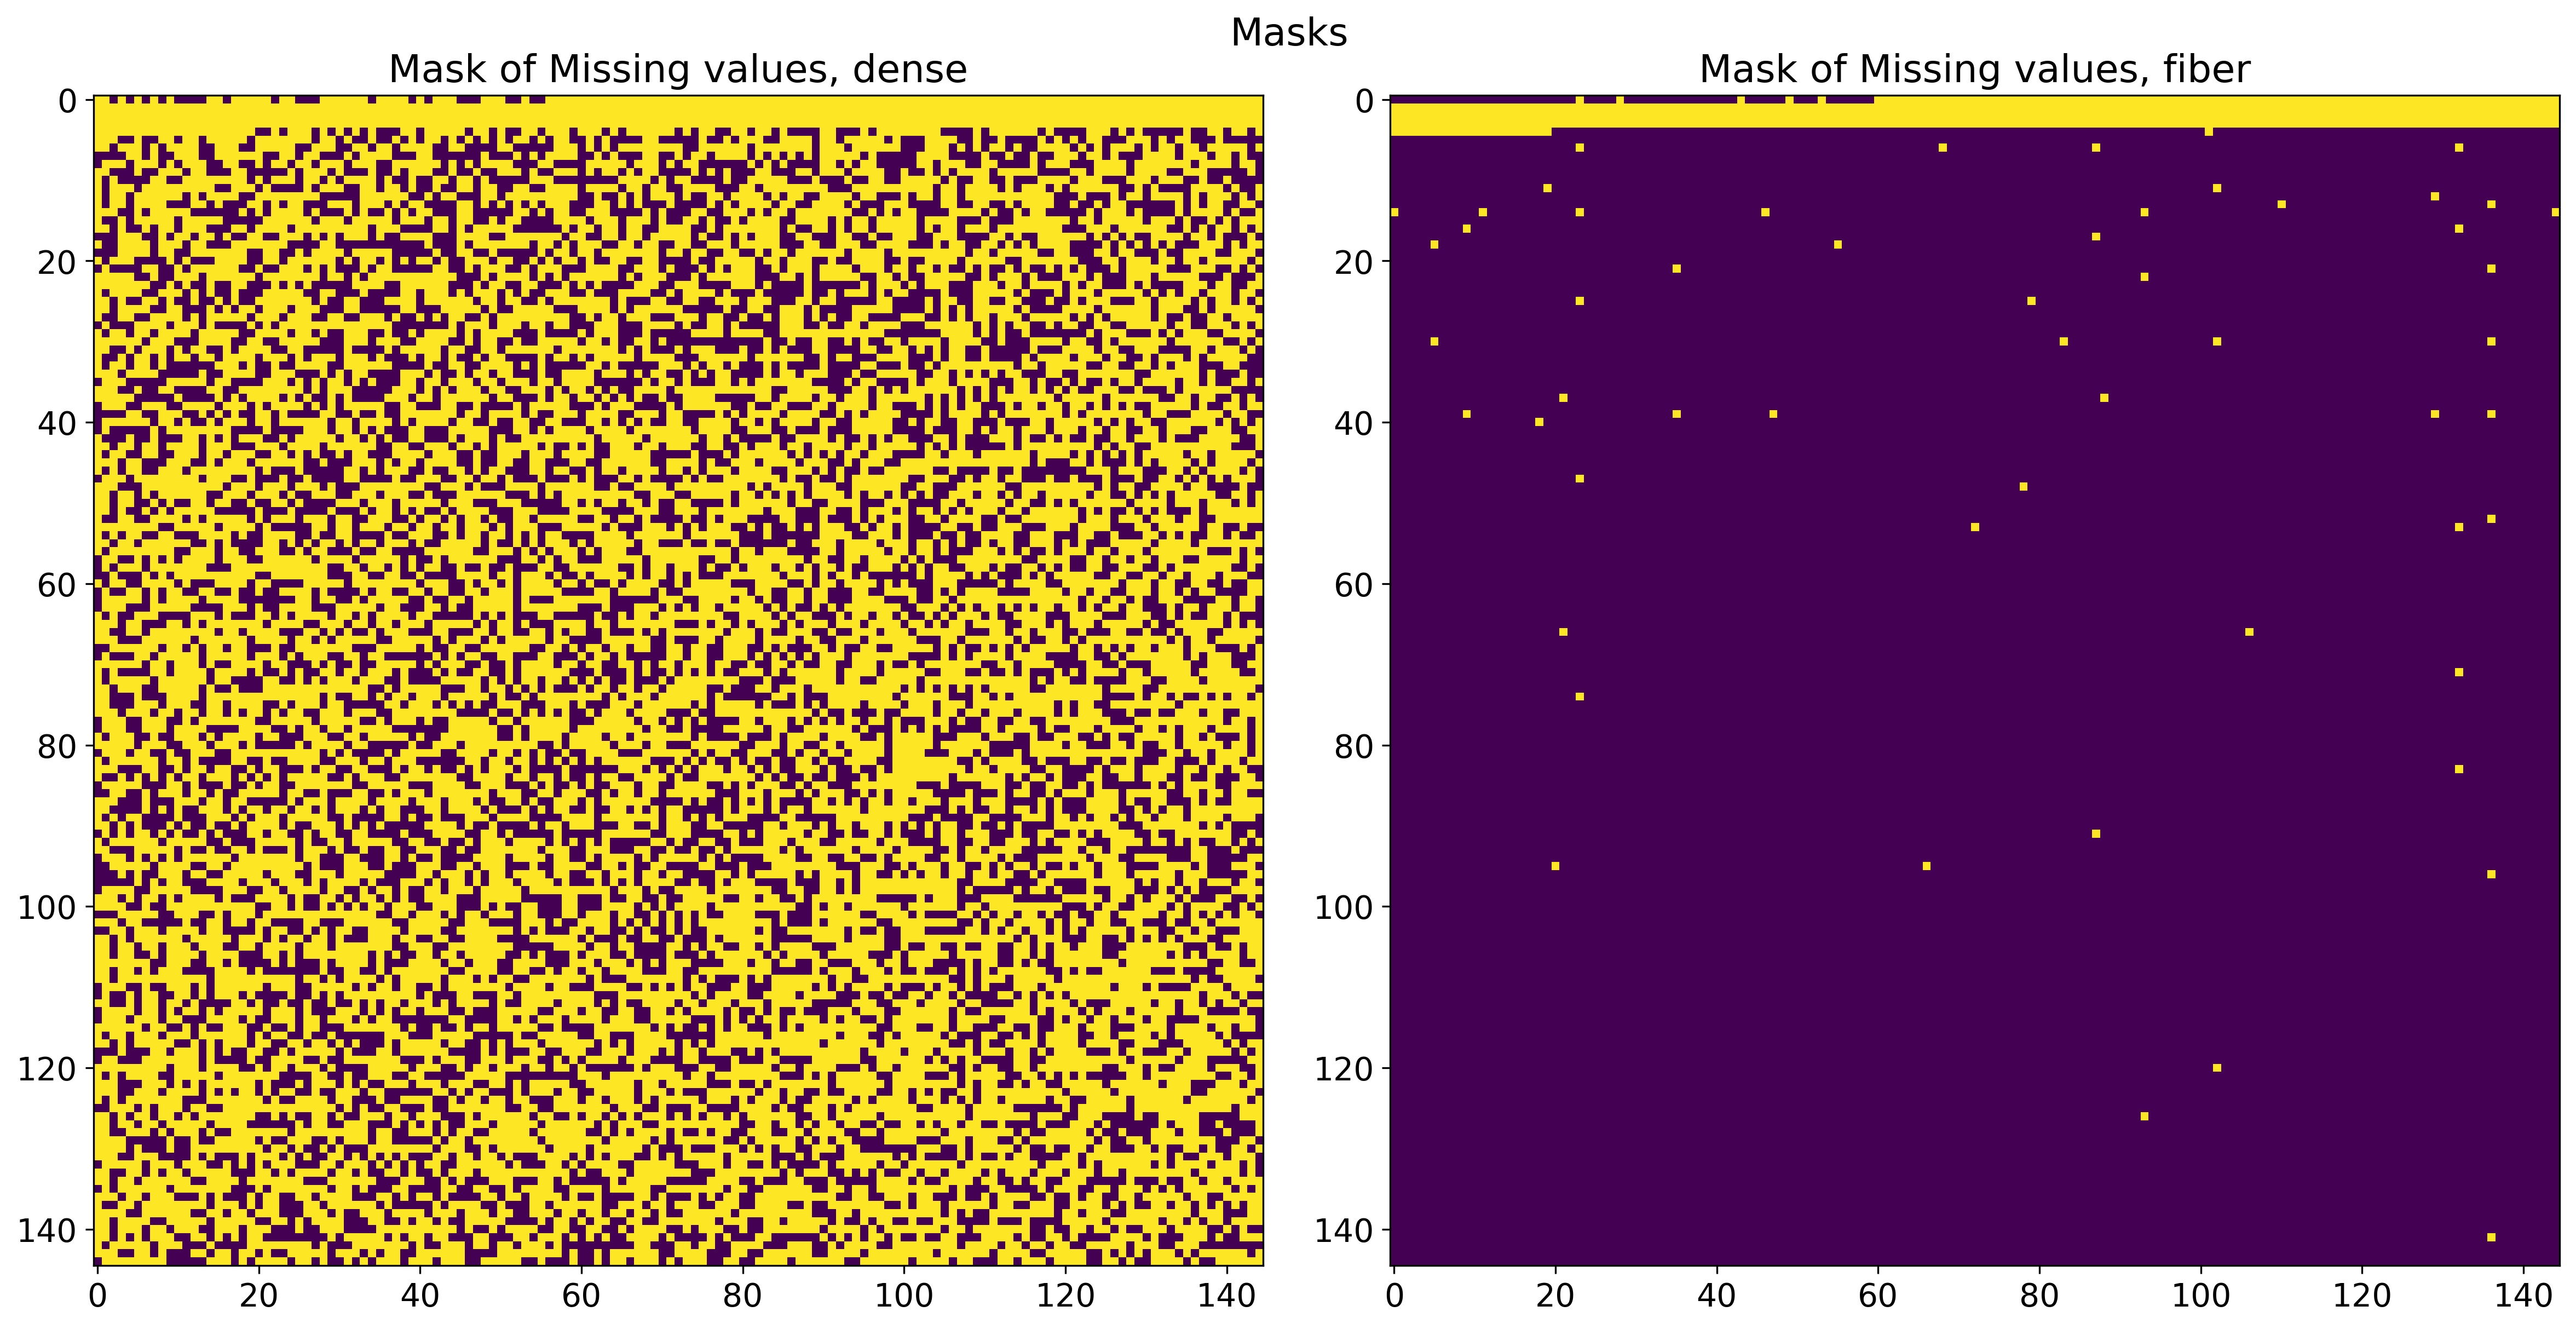

In [153]:

fig,ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle("Masks")

plt.subplot(1,2,1)
plt.imshow(result[5][:,:,np.argmax(slice_sample_counts)])
plt.title("Mask of Missing values, dense")


plt.subplot(1,2,2)
plt.imshow(result[5][:,:,np.argmin(slice_sample_counts)])
plt.title("Mask of Missing values, fiber")

plt.tight_layout()
plt.show()


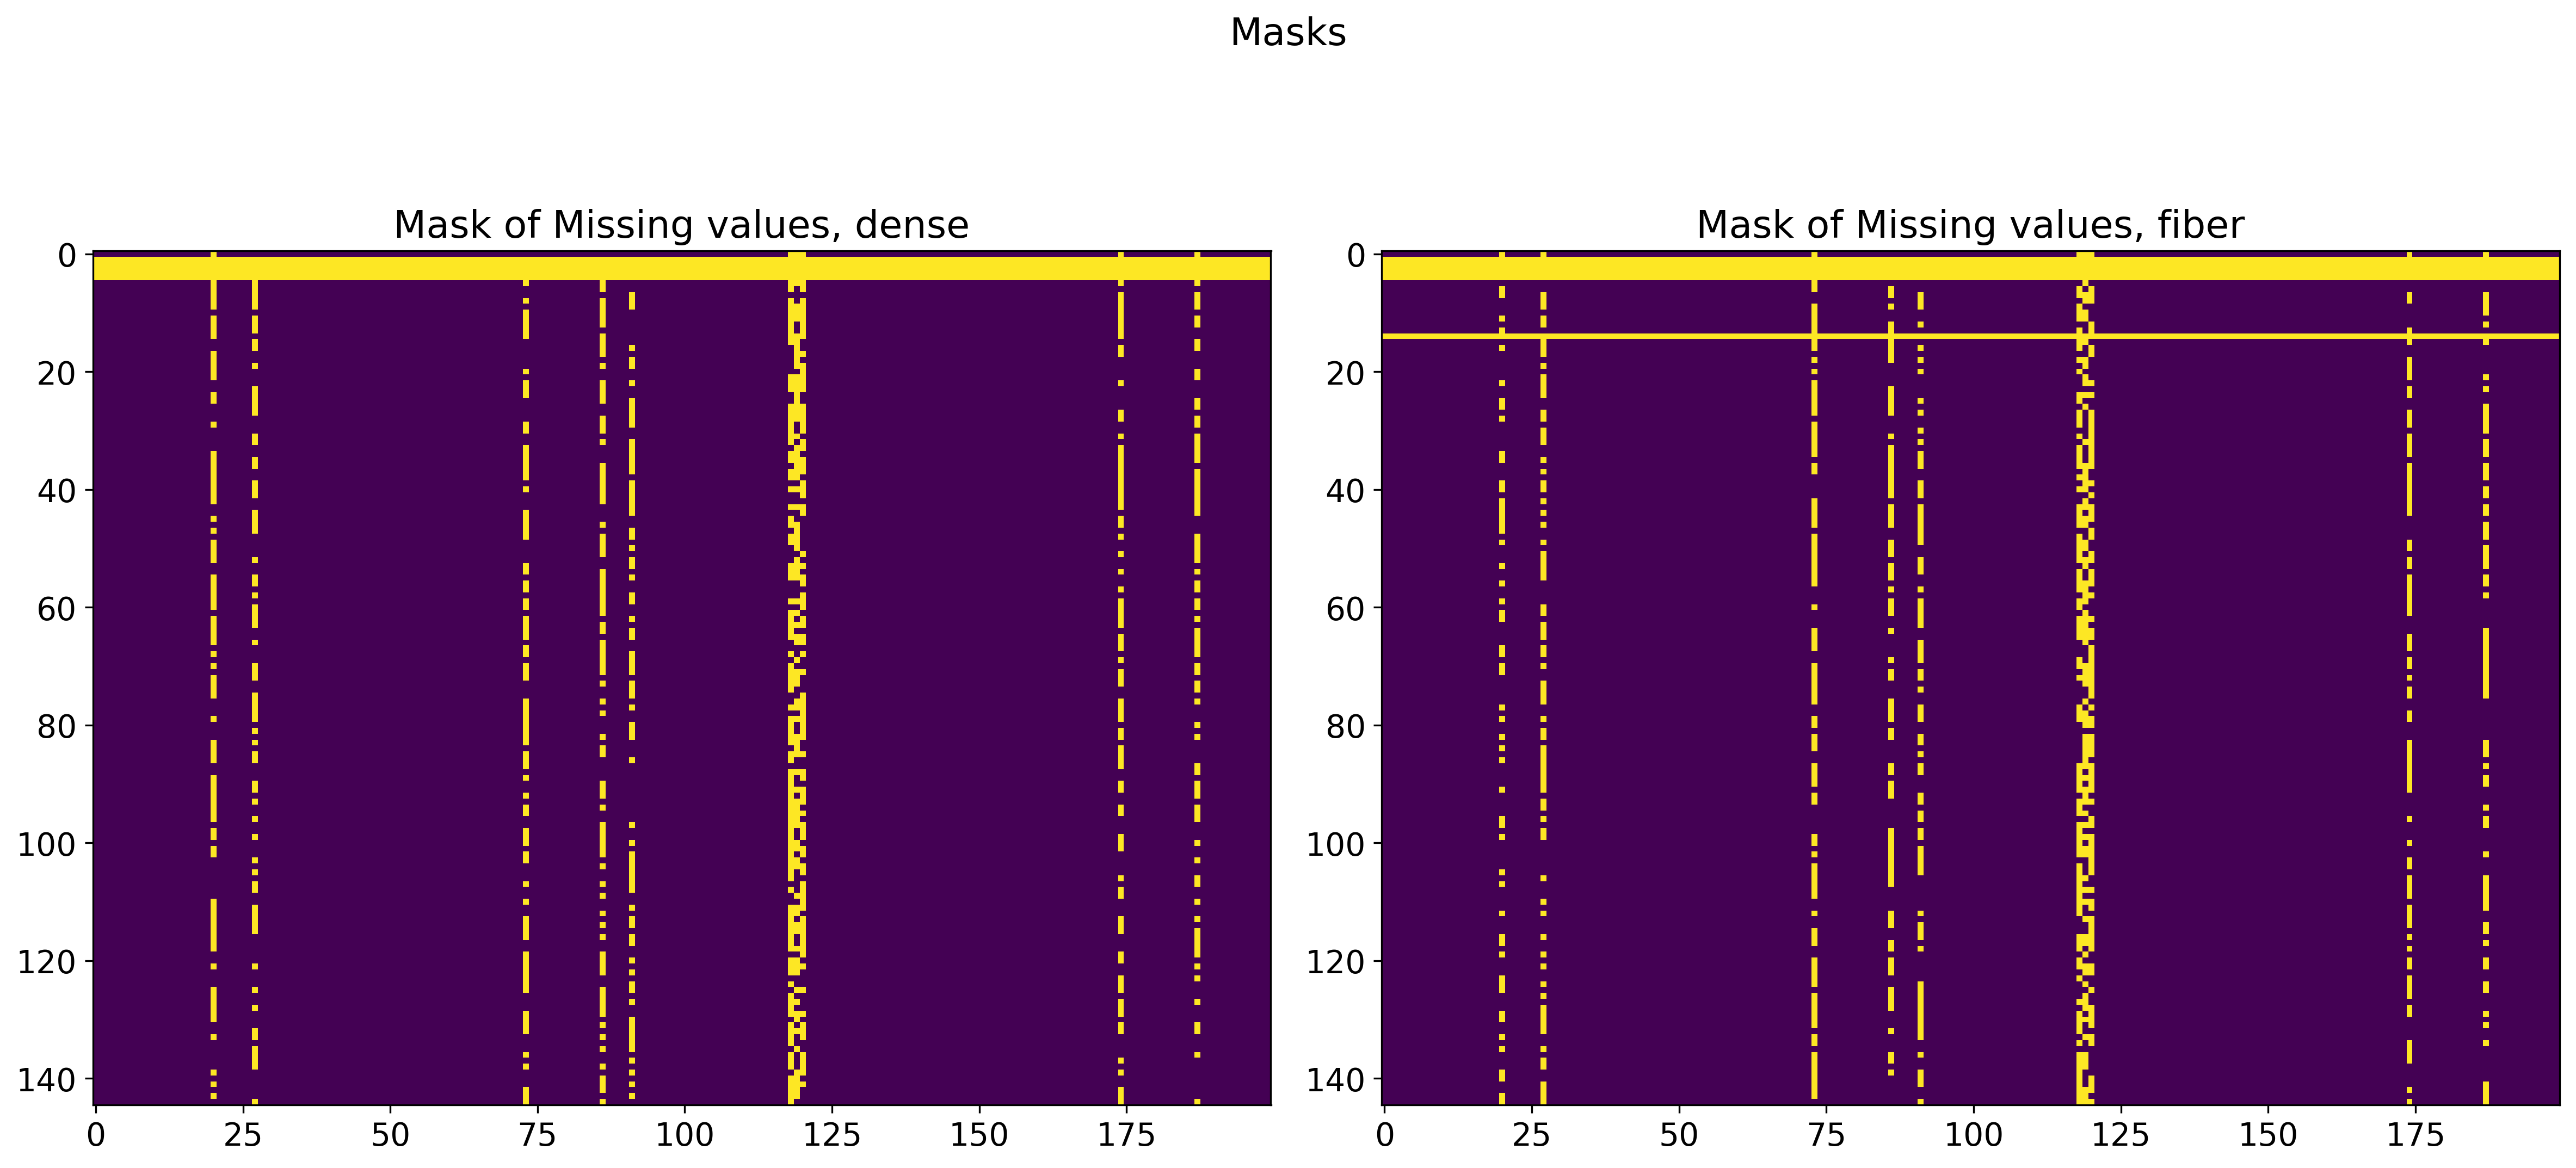

In [154]:

fig,ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle("Masks")

plt.subplot(1,2,1)
plt.imshow(result[5][:,2,:])
plt.title("Mask of Missing values, dense")


plt.subplot(1,2,2)
plt.imshow(result[5][:,0,:])
plt.title("Mask of Missing values, fiber")

plt.tight_layout()
plt.show()